# Determinazione della Frontiera di Separabilità Quantistica e della Violazione di Bell tramite metodi di Machine Learning

### Inquadramento Teorico: La Geometria della Separabilità Quantistica

Il problema fisico affrontato in questo lavoro riguarda la caratterizzazione e la classificazione dell'*entanglement* in sistemi bipartiti composti da due qubit. Uno stato quantistico generale di tale sistema è descritto da un'operatore statistico $\rho$, definito tramite una matrice $4\times4$, che deve soddisfare le seguenti richieste:
- Deve essere definito positivo
- Deve valere che $Tr[\rho]=1$

#### Il Criterio di Peres-Horodecki (PPT)
Per sistemi di dimensione $2 \times 2$, la frontiera tra il regime separabile e quello entangled è dettata dal *criterio PPT*, il quale stabilisce che uno stato è separabile se e solo se la sua trasposta parziale $\rho^{T_A}$ possiede autovalori non negativi:
$$\rho^{T_A} \ge 0$$
Questa condizione smette di valere per sistemi di dimensione maggiore, per i quali è possibile controllare solo che un determinato stato sia entangled costruendo un operatore ad hoc, chiamato *Entanglement Witness*.

Questo è un'osservabile Hermitiana $W$ che funge da "confine" matematico tra gli stati separabili e quelli entangled.
Formalmente, un operatore $W$ è un witness se soddisfa due condizioni:
- Per ogni stato separabile $\sigma$, il valore di aspettazione è non negativo:
    $$Tr(W\sigma)≥0$$
- Esiste almeno uno stato entangled $\rho_{ent}$ per il quale il valore di aspettazione è negativo:
    $$Tr(W\rho_{ent})<0$$

Se misuriamo un valore negativo lo stato è certamente entangled. Se il valore è positivo, il test è inconcludente (lo stato potrebbe essere separabile o semplicemente un tipo di entanglement che quel Witness non riesce a vedere).

### Creazione del dataset
Per addestrare il modello, ho creato un dataset bilanciato composto da stati separabili e stati entangled. Poiché la probabilità di ottenere uno stato separabile tramite campionamento casuale nello spazio di Hilbert totale è significativamente inferiore rispetto a quella di ottenere uno stato entangled, sono state adottate due strategie di generazione distinte:
#### Stati Separabili (Costruzione per Prodotto Tensore)
Gli stati separabili sono stati generati artificialmente come prodotto tensore di due sottosistemi indipendenti A e B:
- *Generazione Random*: Per ogni sottosistema, è stata generata una matrice complessa *M* di dimensione *2×2* con entrate distribuite casualmente
- *Positività e Normalizzazione*: Per garantire che la matrice sia un operatore densità valido è stata utilizzata la costruzione: $\rho_i=\frac{MM^{\dagger}}{Tr(MM^{\dagger})}$
- Composizione: Lo stato totale del sistema è stato ottenuto tramite il prodotto tensore: $\rho_{sep}=ρ_A\otimes\rho_B$
#### Stati Entangled (Generazione Globale e Filtraggio)
Per gli stati entangled, si è operato direttamente sullo spazio totale del sistema (4×4):
- *Matrice Globale*: È stata generata una matrice casuale complessa $M_{tot}$ di dimensione 4×4
- *Vincoli Fisici*: Analogamente a prima, la matrice è stata resa un operatore densità tramite la trasformazione: $\rho_i=\frac{MM^{\dagger}}{Tr(MM^{\dagger})}$
- E' stato poi controllato se lo stato fosse effettivamente entangled col criterio PPT, in caso non lo fosse è stato rigenerato.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_classif
import itertools
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.metrics import balanced_accuracy_score
%load_ext autoreload
%autoreload 2
from funzioni import *

## Caricamento del dataset e calcolo di Entropia di Entanglement, Purezza ed Entropia di Von Neumann
Definiamo le quantità che andremo a calcolare, per avere un'idea di come sono distribuiti gli stati nel dataset:
- *Purezza*: $\mu=Tr[\rho^2]$
- *Entropia di Entanglement*: $\rho_A=Tr_B(\rho_{AB})$, $S(\rho_A)=-Tr(\rho_Aln\rho_A)$
- *Entropia di Von Neumann*: $S(\rho)=-Tr(\rho ln\rho)$

In [2]:
df = pd.read_csv('quantum_data_rich.csv')

print(f"Dimensioni del dataset: {df.shape}")
df.head()

# Le feature sono le prime 32 colonne
X = df.iloc[:, :32]

# I target sono le ultime colonne
y_entangled = df['is_entangled']
y_bell = df['violates_bell']
s_values = df['bell_value']

# Applichiamo la funzione al dataset per creare le nuove colonne
df['entanglement_entropy'] = df.apply(calculate_entanglement_entropy, axis=1) # axis=1 vuol dire che lo faccio riga per riga
df['purity'] = df.apply(calculate_purity, axis=1)
df['state_entropy'] = df.apply(calculate_state_entropy, axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dimensioni del dataset: (10000, 35)


## Distribuzione valori di Bell nel dataset
Questo istogramma rappresenta la distribuzione statistica del valore di Bell (dato dalla disuguaglianza CHSH) calcolato per gli stati quantistici generati nel dataset. L'analisi di questa distribuzione è fondamentale per validare la qualità fisica dei dati prima dell'addestramento dei modelli.

Nel grafico sono evidenziati due limiti teorici cruciali:

- *Limite Classico ($S=2$):* Rappresenta il confine stabilito dalla disuguaglianza CHSH. Gli stati con $S≤2$ possono essere descritti da teorie a variabili nascoste locali
- *Limite di Tsirelson (S=$2\sqrt{2}≈2.828$):* Indica il valore massimo di violazione permesso dalle leggi della meccanica quantistica. La densità dei punti in prossimità di questo limite indica la presenza nel dataset di stati massimamente entangled

### Metodologia di calcolo: Il Criterio di Horodecki

Il valore di Bell non è stato stimato tramite misure casuali, ma calcolato analiticamente per ogni stato $\rho$ utilizzando il *Criterio di Horodecki*. Questo metodo permette di determinare la violazione massima della disuguaglianza CHSH seguendo tre passaggi matematici:

- *Costruzione della matrice di correlazione (T):* Si calcola una matrice $3×3$ i cui elementi $T_{ij}$ sono i valori di aspettazione dei prodotti delle matrici di Pauli $\sigma$ sui due qubit:
    $$T_{ij}=Tr(\rho\cdot(\sigma_i\otimes\sigma_j))$$
Questa matrice riassume tutte le correlazioni spin-spin del sistema lungo gli assi $x,y,z$.

- *Analisi spettrale:* Si considera la matrice $M=T^TT$ e si estraggono i suoi tre autovalori $(u_1,u_2,u_3)$. Questi rappresentano la "forza" delle correlazioni lungo le direzioni principali dello spazio di Hilbert.

- *Determinazione del valore massimo:* Secondo il teorema, il valore massimo della violazione di Bell per lo stato dato è funzione dei due autovalori maggiori della matrice M (che indichiamo come $u_{max}$ e $u_{second\,max}$):
    $$S=2\sqrt{u_{max}+u_{second\,max}}$$

Questo approccio garantisce che l'etichetta fornita sia il limite superiore teorico della non-località per quello specifico stato, rendendo l'addestramento estremamente preciso rispetto alla fisica sottostante.

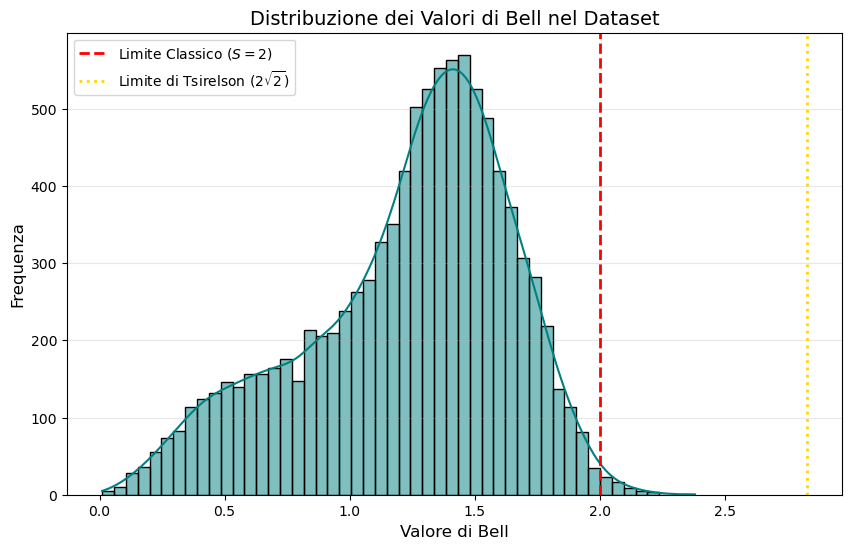

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['bell_value'], bins=50, kde=True, color='teal')

plt.axvline(2.0, color='red', linestyle='--', linewidth=2, label='Limite Classico ($S=2$)')
plt.axvline(2.828, color='gold', linestyle=':', linewidth=2, label='Limite di Tsirelson ($2\sqrt{2}$)')

plt.title('Distribuzione dei Valori di Bell nel Dataset', fontsize=14)
plt.xlabel('Valore di Bell', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## Entropia di Von Neumann e Purezza
Nella teoria dell'informazione quantistica, la caratterizzazione di uno stato non può prescindere dalla valutazione del suo grado di purezza. Mentre uno stato puro rappresenta un sistema di cui si ha informazione completa, uno stato misto riflette una conoscenza parziale, dovuta all'interazione con l'ambiente o a fluttuazioni statistiche. Per quantificare questo aspetto, si utilizzano due metriche complementari: la *Purezza* e l'*Entropia di von Neuman*.
- La Purezza ($\mu$) indica quanto lo stato sia "vicino" ad essere un singolo proiettore. Per un sistema di dimensione $d=4$ (due qubit), la purezza è vincolata nell'intervallo:
$$\frac{1}{d}≤\mu≤1⟹0.25≤\mu≤1$$

   - $\mu=1$: Lo stato è puro ($\rho=\ket{\psi}\bra{\psi}$)

   - $\mu=0.25$: Lo stato è massimamente misto ($\rho=\frac{1}{4}\mathbb{I}$)

- L'Entropia di von Neumann ($S_N$): rappresenta l'estensione quantistica dell'entropia di Shannon e misura il "disordine" o la mancanza di informazione associata a $\rho$. È definita tramite gli autovalori $\lambda_i$ della matrice densità:
$$S_N(\rho)=−Tr(\rho log_2\rho)=−\sum_{i=1}^d\lambda_ilog_2\lambda_i$$

Per un sistema a due qubit, l'entropia varia tra:
$$0≤S_N(\rho)≤log_2(4)⟹0≤S_N(\rho)≤2$$

   - $S=0$: Il sistema è in uno stato puro

   - $S=2$: Il sistema è nel massimalmente misto

Sebbene entrambe le grandezze descrivano la qualità dello stato, esse agiscono in direzioni opposte: all'aumentare del disordine (entropia), la purezza cala drasticamente.

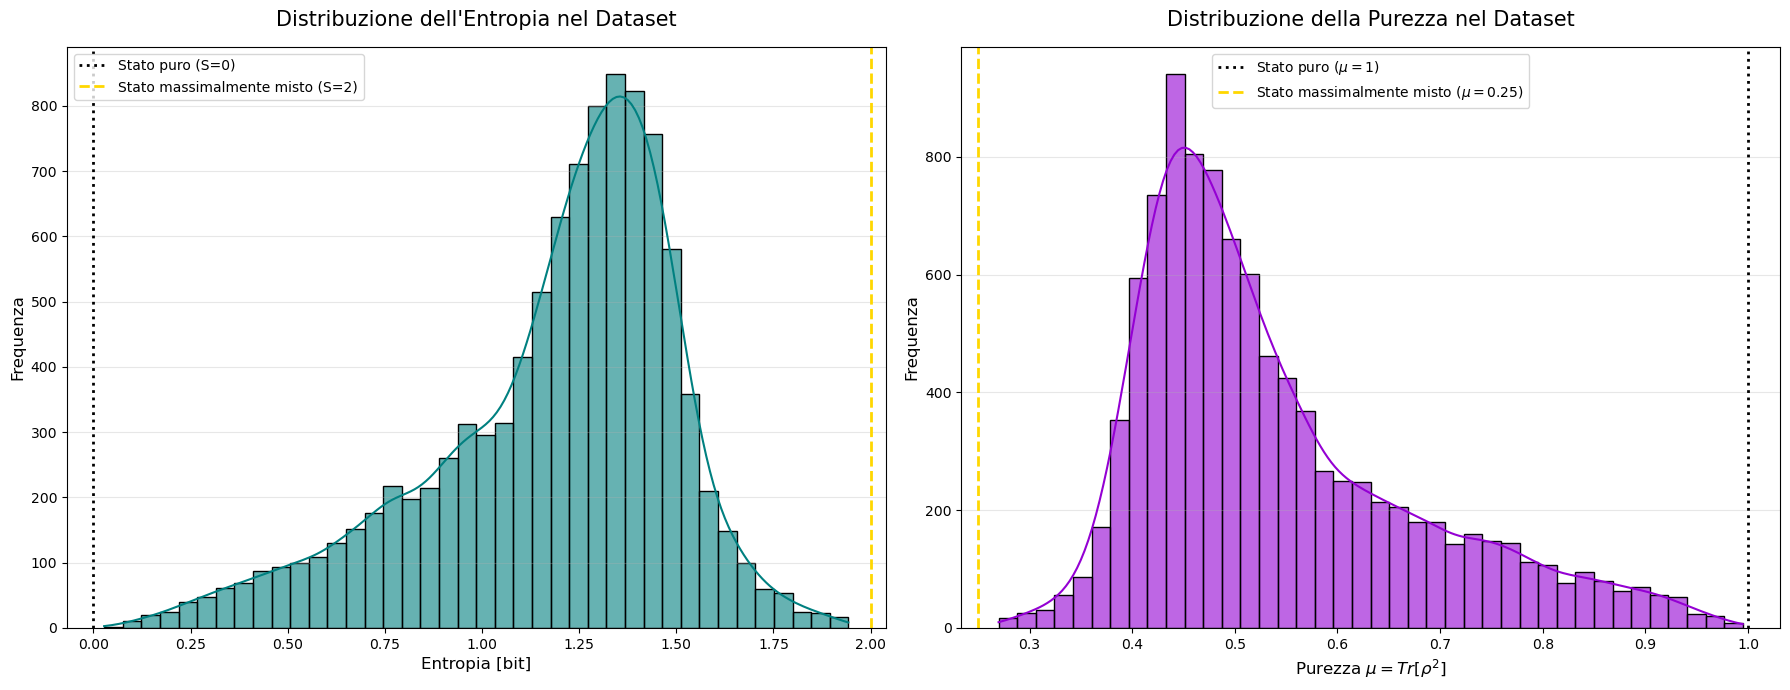

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(df['state_entropy'], bins=40, kde=True, color='teal', alpha=0.6, ax=ax1)

ax1.axvline(0, color='black', linestyle=':', linewidth=2, label='Stato puro (S=0)')
ax1.axvline(2, color='gold', linestyle='--', linewidth=2, label='Stato massimalmente misto (S=2)')

ax1.set_title('Distribuzione dell\'Entropia nel Dataset', fontsize=15, pad=15)
ax1.set_xlabel('Entropia [bit]', fontsize=12)
ax1.set_ylabel('Frequenza', fontsize=12)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)


sns.histplot(df['purity'], bins=40, kde=True, color='darkviolet', alpha=0.6, ax=ax2)

ax2.axvline(1, color='black', linestyle=':', linewidth=2, label='Stato puro ($\mu=1$)')
ax2.axvline(0.25, color='gold', linestyle='--', linewidth=2, label='Stato massimalmente misto ($\mu=0.25$)')

ax2.set_title('Distribuzione della Purezza nel Dataset', fontsize=15, pad=15)
ax2.set_xlabel('Purezza $\mu = Tr[\\rho^2]$', fontsize=12)
ax2.set_ylabel('Frequenza', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Entropia di Entanglement
L’Entropia di Entanglement rappresenta la misura per quantificare il grado di correlazione quantistica tra due sottosistemi (A e B). A differenza dell’entropia totale, che descrive l’incertezza sull’intero sistema, l'entropia di entanglement si focalizza sull'informazione che va perduta quando si tenta di descrivere un singolo sottosistema ignorando le sue correlazioni con l’altro.
Per un sistema composto da due qubit, il sottosistema A è un singolo oggetto a due livelli ($d=2$). Di conseguenza, i limiti dell'entropia di entanglement sono:
$$0≤S_E≤log_2(2)=1$$

- $S_E=0$: Il sistema è separabile. La conoscenza del tutto coincide con la conoscenza delle parti (stato fattorizzato)

- $S_E=1$: Il sistema è massimamente entangled. Nonostante il sistema totale possa essere in uno stato puro (informazione massima), il singolo qubit A appare nel massimo disordine possibile (informazione nulla), poiché tutta l'informazione risiede esclusivamente nelle correlazioni non-locali

È cruciale distinguere l'interpretazione di $S_E$ in base alla purezza dello stato globale:

- Negli *stati puri* ($\mu=1$), $S_E$ è una misura "pulita" di entanglement: ogni bit di entropia nel sottosistema deriva necessariamente da correlazioni quantistiche

- Negli *stati misti* ($\mu<1$), $S_E$ include sia contributi di entanglement che contributi di rumore classico

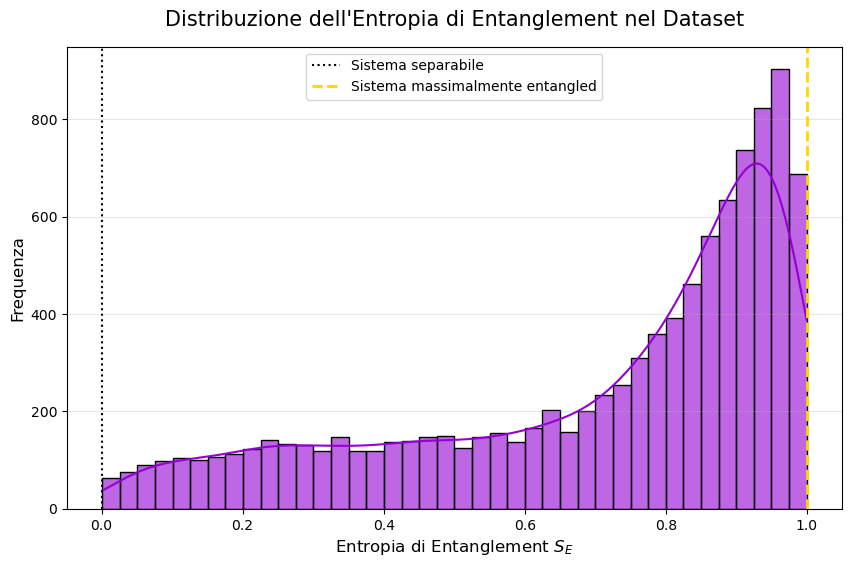

In [5]:
plt.figure(figsize=(10, 6))

sns.histplot(df['entanglement_entropy'], bins=40, kde=True, color='darkviolet', alpha=0.6)

plt.axvline(0, color='black', linestyle=':', linewidth=1.5, label='Sistema separabile')
plt.axvline(1, color='gold', linestyle='--', linewidth=2, label='Sistema massimalmente entangled')

plt.title('Distribuzione dell\'Entropia di Entanglement nel Dataset', fontsize=15, pad=15)
plt.xlabel('Entropia di Entanglement $S_E$', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

## Analisi del Criterio Entropico di Separabilità e Disuguaglianza di Araki-Lieb
In fisica classica, l'entropia di un sistema composto non può mai essere inferiore all'entropia delle sue singole parti; tuttavia, in meccanica quantistica, la disuguaglianza di Araki-Lieb stabilisce che:
$$ |S(\rho_A) - S(\rho_B)| \le S(\rho_{AB}) $$
Per stati separabili (puramente classici o misti senza entanglement), vale la condizione stringente $S(\rho_A) \le S(\rho_{AB})$.

Nel grafico, questa condizione è rappresentata dalla *bisettrice del quadrante* ($S_E = S_{global}$). I punti che risiedono al di sotto di questa frontiera includono sia stati separabili che stati entangled caratterizzati da un alto grado di rumore. Al contrario, la regione superiore (evidenziata in rosso), dove $S(\rho_A) > S(\rho_{AB})$, rappresenta una zona *puramente quantistica*: la presenza di punti in quest'area è una prova fenomenologica dell'entanglement, poiché indica che il sistema globale è più ordinato e possiede una conoscenza più definita rispetto alle sue singole componenti.

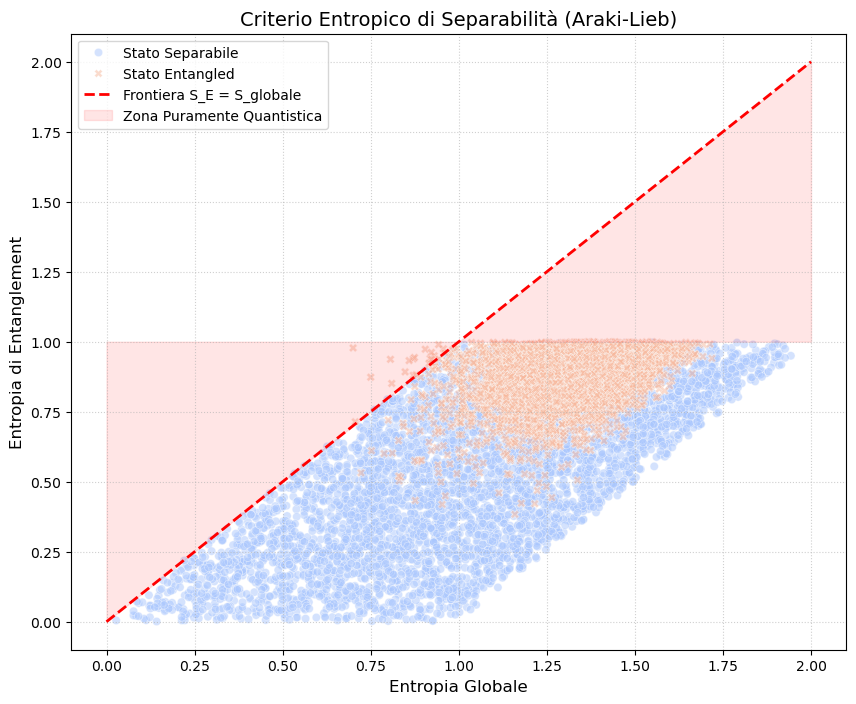

In [6]:
df['is_entangled'] = df['is_entangled'].map({0: 'Stato Separabile', 1: 'Stato Entangled'})

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df, 
    x='state_entropy', 
    y='entanglement_entropy', 
    hue='is_entangled', 
    style='is_entangled',
    palette='coolwarm',
    alpha=0.5
)

x_vals = np.linspace(0, 2, 100)
plt.plot(x_vals, x_vals, 'r--', lw=2, label='Frontiera S_E = S_globale')

plt.fill_between(x_vals, x_vals, 1, color='red', alpha=0.1, label='Zona Puramente Quantistica')

plt.title('Criterio Entropico di Separabilità (Araki-Lieb)', fontsize=14)
plt.xlabel('Entropia Globale', fontsize=12)
plt.ylabel('Entropia di Entanglement', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Matrici di correlazione
Prima di procedere con la fase di modellazione, è stata effettuata un'analisi sistematica della matrice di correlazione tra le feature grezze (le componenti reali e immaginarie della matrice densità) e tra queste e il valore di Bell.

#### Ridondanza Interna e Vincoli Fisici
La prima heatmap analizza la *correlazione mutua* tra le 32 feature di input. Come atteso dalla teoria, si osserva una forte ridondanza informativa derivante dai vincoli strutturali della meccanica quantistica:
- *Hermiticità e Unicità della Traccia:* il fatto che $\text{Tr}(\rho)=1$ e che $\rho = \rho^\dagger$ implica che non tutti i 32 parametri siano indipendenti
- *Multicollinearità:* L'osservazione di blocchi altamente correlati nella matrice indica che il sistema risiede in un sottospazio dello spazio dei parametri. Questa ridondanza giustifica matematicamente l'applicazione della *Principal Component Analysis* (PCA) per proiettare i dati in una base ortogonale di dimensioni ridotte senza perdita significativa di informazione fisica

#### Sensibilità delle Feature rispetto al Target di Bell
La seconda analisi mostra la correlazione tra le componenti della matrice densità e il parametro di Bell. Questa mappa di calore funge da indicatore di *Feature Importance*:
- *Elementi Off-Diagonal:* si nota come gli elementi fuori dalla diagonale principale ($\rho_{ij}$ con $i \ne j$) mostrino i coefficienti di correlazione più elevati con il valore di Bell. Fisicamente, ciò riflette il fatto che la non-località e l'entanglement sono codificati nelle *coerenze quantistiche* dello stato, piuttosto che nelle semplici popolazioni (elementi diagonali).

In sintesi, l'analisi delle correlazioni conferma che l'informazione necessaria per discriminare la non-località è distribuita in modo non uniforme tra le componenti di $\rho$, identificando nelle coerenze quantistiche i driver principali della violazione di Bell.

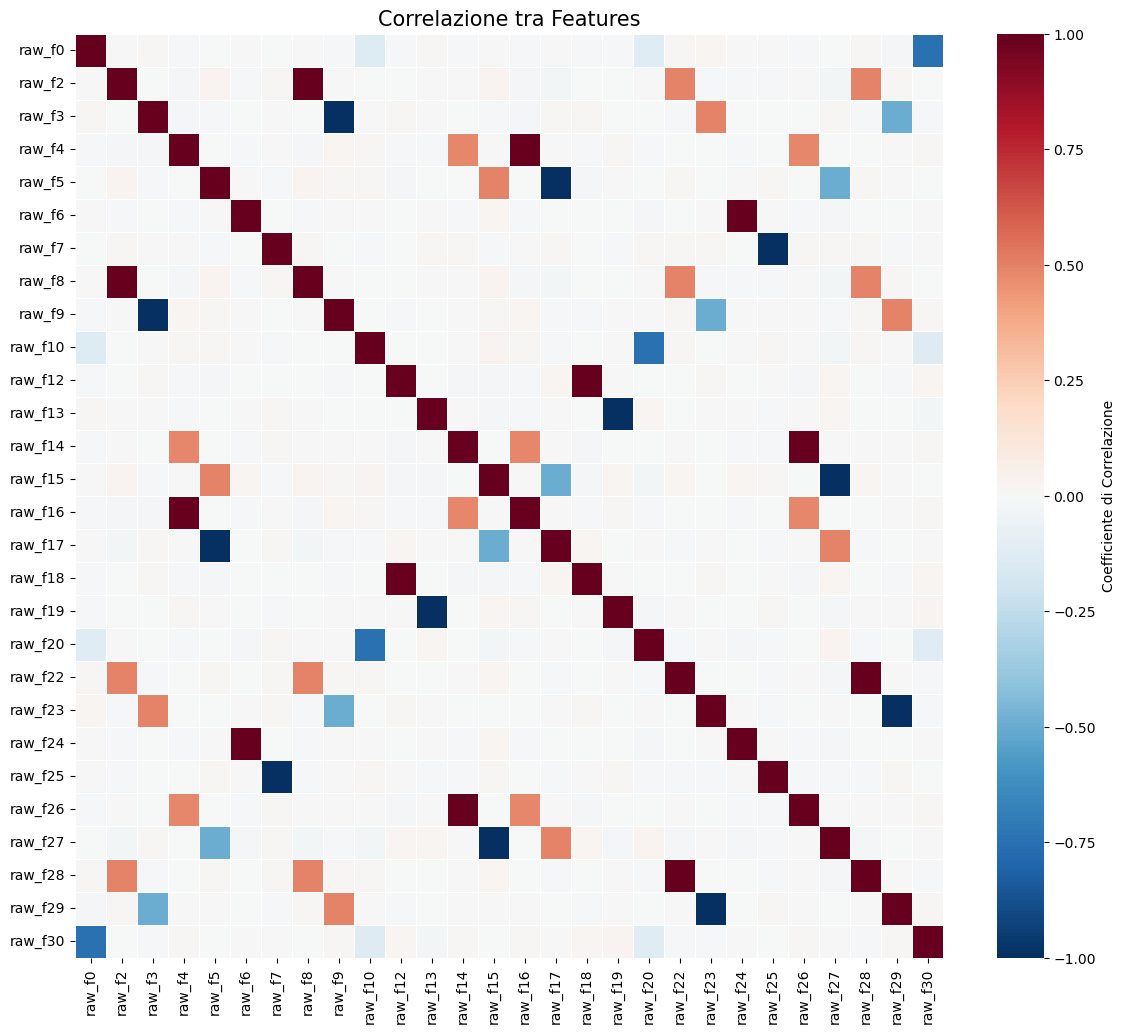

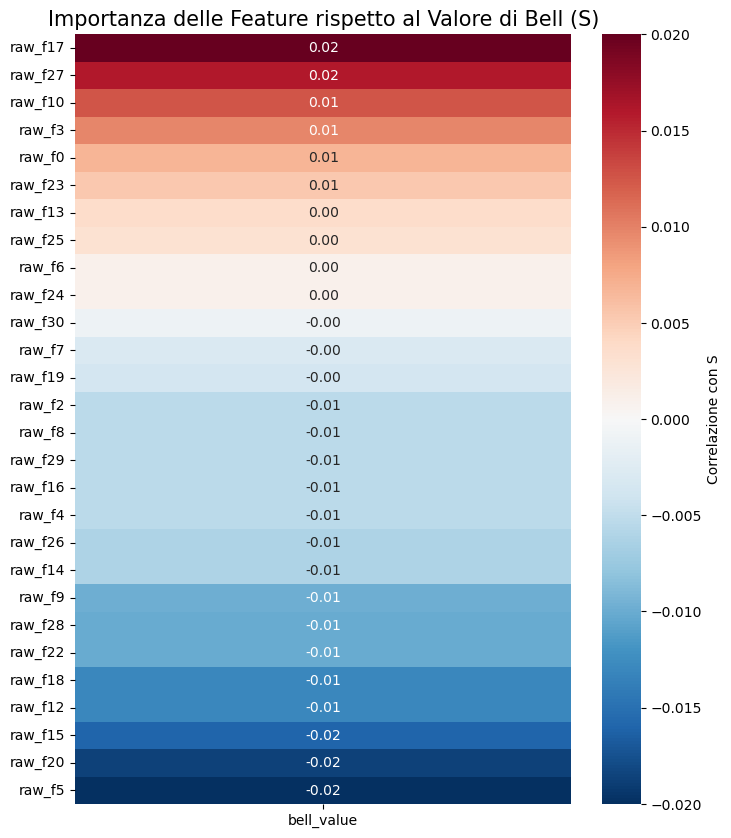

In [7]:
features = df.filter(like='raw')

# Togliamo le colonne che non variano mai
features_clean = features.loc[:, features.std() > 0]

# Correlazione di ogni feature con le altre
plt.figure(figsize=(14, 12))
corr_features = features_clean.corr()

sns.heatmap(corr_features, 
            cmap='RdBu_r', 
            center=0, 
            annot=False, 
            linewidths=.5,
            cbar_kws={"label": "Coefficiente di Correlazione"})

plt.title('Correlazione tra Features', fontsize=15)
plt.show()


# Correlazione di tutte le feature con il valore di Bell
bell_corr = df[list(features_clean.columns) + ['bell_value']].corr()[['bell_value']]
bell_corr = bell_corr.drop('bell_value').sort_values(by='bell_value', ascending=False)

plt.figure(figsize=(8, 10))
sns.heatmap(bell_corr, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            fmt=".2f",
            cbar_kws={"label": "Correlazione con S"})

plt.title('Importanza delle Feature rispetto al Valore di Bell (S)', fontsize=15)
plt.show()

## Analisi dell'Importanza delle Feature tramite Informazione Mutua

Per identificare quali parametri fisici contribuiscano maggiormente alla capacità predittiva dei modelli, ho condotto un'analisi basata sull'*informazione mutua*. A differenza della correlazione lineare, questa misura la dipendenza statistica tra le variabili quantificando la riduzione di incertezza sul target (la violazione di Bell) data la conoscenza di una specifica feature.

#### Catturare la Non-Linearità Quantistica
Il calcolo del valore di Bell attraverso il criterio di Horodecki coinvolge operazioni non-lineari sugli autovalori della matrice di correlazione ($S = 2\sqrt{u_1 + u_2}$). In questo contesto, l'uso dell'informazione mutua risulta superiore ai metodi basati sulla varianza lineare, poiché permette di individuare feature che, pur non avendo un legame proporzionale diretto con il valore di Bell, ne condizionano la distribuzione di probabilità.

#### Interpretazione dei Risultati
Dall'analisi delle prime dieci feature per punteggio di importanza, emergono i seguenti aspetti:
- *Predominanza delle Feature Ingegnerizzate:* Come previsto, l'Entropia di Entanglement e la Purezza occupano le prime posizioni. Questo conferma che queste grandezze condensate estraggono l'essenza fisica necessaria alla classificazione della non-località, agendo come descrittori globali dello stato.
- *Gerarchia delle Componenti di Pauli:* Tra le feature grezze, quelle con punteggi di informazione mutua più elevati corrispondono alle coerenze quantistiche ($\rho_{ij}$ con $i \ne j$). Ciò indica che l'informazione mutua tra lo stato e la sua violazione locale risiede quasi esclusivamente nei termini di sovrapposizione coerente tra i sottosistemi.

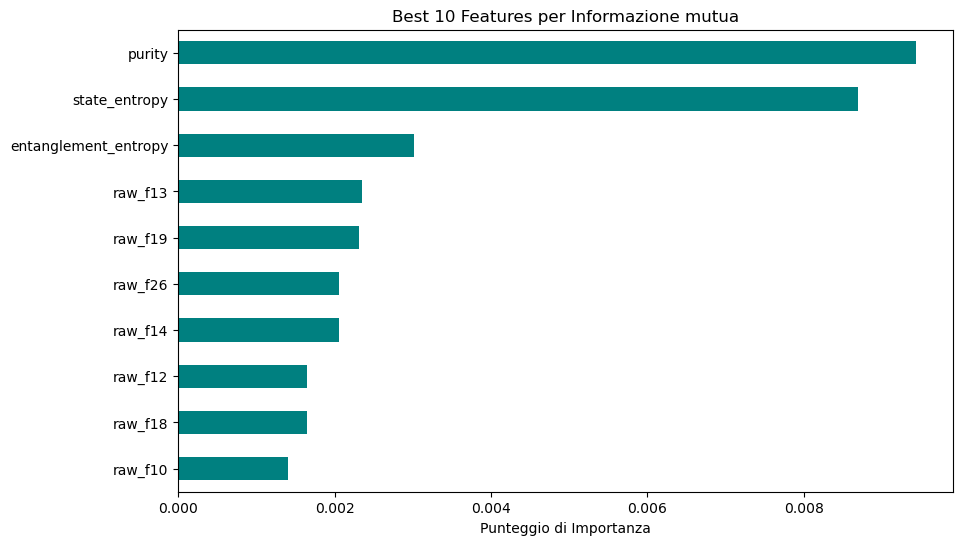

In [8]:
X = df.drop(columns=['is_entangled', 'violates_bell', 'bell_value'])
y = df['violates_bell']

importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, index=X.columns)

plt.figure(figsize=(10, 6))
feat_importances.sort_values().tail(10).plot(kind='barh', color='teal')
plt.title('Best 10 Features per Informazione mutua')
plt.xlabel('Punteggio di Importanza')
plt.show()

## Riduzione della Dimensionalità tramite PCA

L'elevata dimensionalità del dataset (32 feature grezze per ogni stato) e la ridondanza informativa precedentemente osservata giustificano l'applicazione della *Principal Component Analysis* (PCA). Questa tecnica permette di proiettare i dati in un nuovo spazio di dimensione minore di variabili ortogonali, le componenti principali, ordinate in base alla varianza.

#### Analisi della Varianza
Il grafico della varianza cumulata mostra una rapida saturazione dell'informazione. Si osserva che:
- *Compressione dell'Informazione:* una frazione significativa della varianza totale è catturata dalle prime componenti principali. Questo indica che la dinamica del sistema, pur essendo descritta da 32 parametri reali e immaginari, risiede effettivamente su una varietà di dimensione inferiore.
- *Soglia del 95\%:* Il raggiungimento della soglia critica del 95\% della varianza con un numero ridotto di componenti conferma che le restanti componenti rappresentano prevalentemente rumore numerico o dettagli irrilevanti ai fini della classificazione della non-località.

#### Implicazioni
L'utilizzo delle componenti principali come input per i classificatori successivi offre due vantaggi fondamentali:
- *Efficienza Computazionale:* La riduzione dello spazio delle feature accelera significativamente la fase di addestramento e riduce il rischio di *overfitting*.
- *De-noising:* Escludendo le componenti con varianza quasi nulla, il modello si focalizza sulle direzioni dello spazio di Hilbert dove le differenze tra stati separabili e stati entangled sono statisticamente più marcate.

In conclusione, la PCA agisce come un filtro fisico che estrae la struttura essenziale della matrice densità, trasformando un insieme di parametri matematici grezzi in un set ottimizzato di descrittori quantistici.

#### PCA
La PCA si basa sulla decomposizione ai valori singolari (SVD):
$$X=U\Sigma V^T$$
Dove:
- $U$: Matrice unitaria
- $\Sigma$: Matrice diagonale contenente i valori singolari $\sigma_i$, ordinati tali che $\sigma_1≥\sigma_2≥...≥\sigma_d≥0$.
- $V^T$: Matrice unitaria
  
La matrice di covarianza dei dati standardizzati è definita come: 
$$C=\frac{X^TX}{n-1}$$
Gli autovalori $\lambda_i$ di questa matrice rappresentano la varianza lungo ogni componente principale e sono legati ai valori singolari $\sigma_i$ dalla relazione:
$$\lambda_i=\frac{\sigma_i^2}{n-1}$$
Nel grafico, la *Varianza individuale* corrisponde ai questi $\lambda_i$ normalizzati.

Per quantificare quanta informazione viene mantenuta riducendo le dimensioni, calcoliamo il rapporto tra la varianza della singola componente e la varianza totale:
$$Ratio_k=\frac{\lambda_k}{\sum_{i=1}^d\lambda_i}=\frac{\sigma_k^2}{\sum_{i=1}^d\sigma_i^2}$$
Questo valore indica la frazione di informazione del dataset originale contenuta nella k-esima componente principale.
La *Varianza cumulata* nel grafico rappresenta la somma progressiva dei rapporti di varianza:
$$Cumulata(K)=\sum_{k=1}^KRatio_k$$

Il target del 95\% identifica il numero minimo di componenti K tale per cui:
$$Cumulata(K)≥0.95$$

Valori singolari corrispondenti alle prime 14 componenti:
[176.05869677 173.67020861 171.38416721 170.92387584 142.73456776
 141.42497387 141.00714116 140.58451783 131.8595576  131.72033963
 102.34923202 100.34184627 100.03956946  99.3306925 ]

Peso relativo dei primi 14 valori singolari: 96.43%


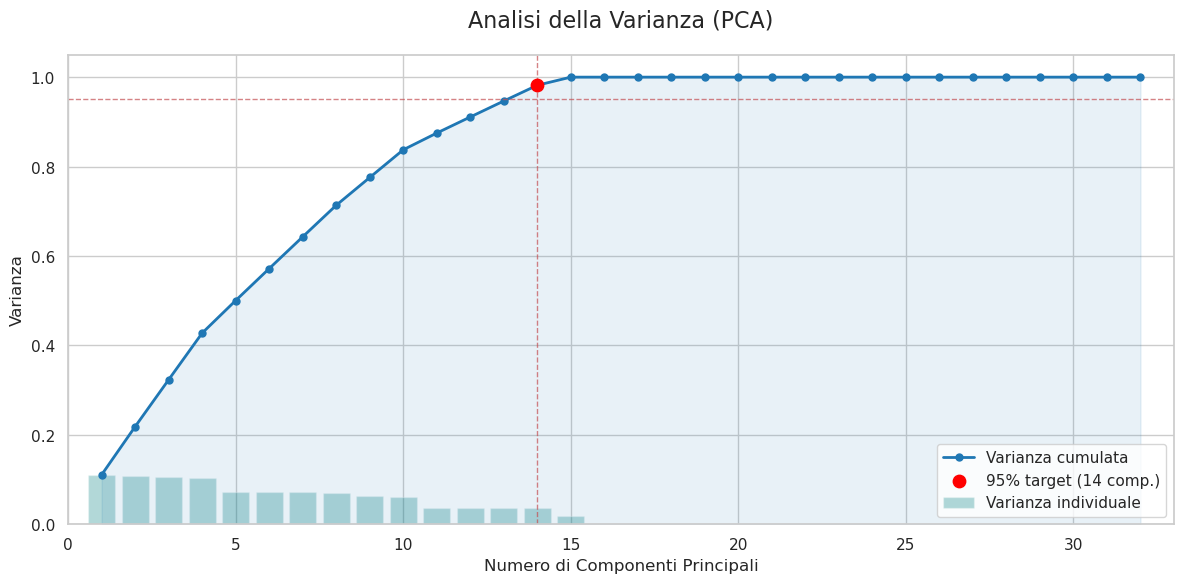

In [9]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

X = df.filter(like='raw')
X_scaled = StandardScaler().fit_transform(X) # matrice di covarianza dei dati scalati è identica alla matrice di correlazione dei dati originali
pca = PCA().fit(X_scaled)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
# Troviamo il numero di componenti per il 95%
n_95 = np.argmax(cum_var >= 0.95) + 1

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(range(1, len(exp_var) + 1), exp_var, alpha=0.3, color='teal', label='Varianza individuale')
ax1.plot(range(1, len(cum_var) + 1), cum_var, marker='o', markersize=5, 
         linewidth=2, color='#1f77b4', label='Varianza cumulata')
ax1.fill_between(range(1, len(cum_var) + 1), cum_var, alpha=0.1, color='#1f77b4')
ax1.axhline(y=0.95, color='r', linestyle='--', linewidth=1, alpha=0.7)
ax1.axvline(x=n_95, color='r', linestyle='--', linewidth=1, alpha=0.7)
ax1.scatter(n_95, cum_var[n_95-1], color='red', s=80, zorder=5, label=f'95% target ({n_95} comp.)')

ax1.set_title('Analisi della Varianza (PCA)', fontsize=16, pad=20)
ax1.set_xlabel('Numero di Componenti Principali', fontsize=12)
ax1.set_ylabel('Varianza', fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.set_xlim(0, len(cum_var) + 1)

plt.legend(loc='lower right', frameon=True)
plt.tight_layout()

singular_values = pca.singular_values_

print(f"Valori singolari corrispondenti alle prime {n_95} componenti:")
print(singular_values[:n_95])

total_sv_sum = np.sum(singular_values)
print(f"\nPeso relativo dei primi {n_95} valori singolari: {np.sum(singular_values[:n_95]) / total_sv_sum:.2%}")

## Regressione logistica

Dopo la riduzione della dimensionalità, è stata implementata una *Regressione Logistica* come modello di baseline per la classificazione binaria degli stati. L'obiettivo è duplice: discriminare tra stati separabili ed entangled e, in seconda istanza, identificare gli stati che violano la disuguaglianza di Bell.

#### Metodologia di Addestramento
Il dataset proiettato nello spazio PCA è stato suddiviso in un set di addestramento (80\%) e un set di test (20\%). Per compensare eventuali sbilanciamenti tra le classi (specialmente nella violazione di Bell, statisticamente più rara), è stata utilizzata una funzione di costo pesata *balanced class weights*.
Quest'ultima calcola i pesi nel seguente modo: $$W_j=\frac{n_{samples}}{n_{classes}\times n_{classes_{j}}}$$

Per la classificazione binaria, la funzione di costo ottimizzata dal modello è la *Binary Cross Entropy* (BCE). Questa funzione misura la discrepanza tra le probabilità predette $\hat{y}$ e le etichette reali $y$. L'integrazione dei pesi bilanciati modifica la funzione di costo come segue:
$$L=-\frac{1}{n}\sum_{i=1}^nW_i[y_iln(\hat{y}_i)+(1-y_i)ln(1-\hat{y}_i)]$$

In questo modo, l'errore commesso sulle classi minoritarie pesa maggiormente nel calcolo del gradiente, forzando il modello ad apprendere con maggiore precisione i confini di tali regioni.

L'iperpiano decisionale cercato dal modello rappresenta il tentativo di separare le diverse regioni dello spazio di Hilbert utilizzando combinazioni lineari delle componenti principali.

#### Analisi delle Matrici di Confusione e Report
Le performance del modello, visualizzate tramite le matrici di confusione, permettono di trarre le seguenti conclusioni:
-  *Accuratezza e Robustezza:* un'elevata accuratezza su entrambi i target indica che le componenti principali estratte conservano le feature fisiche necessarie alla classificazione.
- *Precision e Recall:* il *Classification Report* evidenzia la capacità del modello di minimizzare i falsi positivi (stati classici scambiati per quantistici). Nel caso della violazione di Bell, la metrica F1-score risulta particolarmente indicativa della capacità dell'algoritmo di individuare il confine critico.
Abbiamo le seguenti definizioni:
$$Precision=\frac{VP}{VP+FP}$$ con VP veri positivi ed FP falsi positivi
$$Recall=\frac{VP}{VP+FN}$$ con VP veri positivi ed FN falsi negativi
$$F_1=\frac{Precision\cdot Recall}{Precision+Recall}$$
- *Support*: quanti campioni di quella classe c'erano nel set di test
- *Accuracy*: percentuale totale di previsioni corrette su tutto il dataset
- *Macro Avg*: calcola la media delle metriche (Precision, Recall, F1) dando lo stesso peso a ogni classe
- *Weighted Avg*: calcola la media pesata in base al Support

## Scelta del parametro C
In questo caso il parametro $C$ è uguale a $1/\lambda$, dove $\lambda$ è il parametro della regolarizzazione di Ridge. L'accuratezza è definita nel seguente modo:
$$Accuracy=\frac{Numero\,\,di\,\,previsione\,\,corrette}{Numero\,\,totale\,\,di\,\,previsioni}$$
Il *Training score* misura quanto bene il modello riesce a "spiegare" o fittare i dati su cui viene allenato, mentre il *Cross-Validation Score* rappresenta l'accuratezza del modello su dati nuovi.

--- RISULTATI OTTIMIZZAZIONE: Entanglement ---
Miglior Valore di C: 0.0001
Accuracy Massima (CV): 50.15%



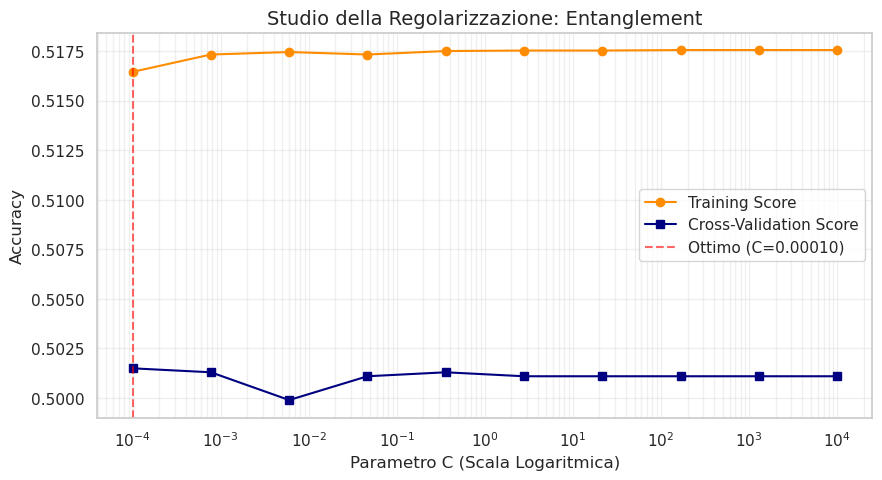

--- RISULTATI OTTIMIZZAZIONE: Violazione di Bell ---
Miglior Valore di C: 0.0001
Accuracy Massima (CV): 60.61%



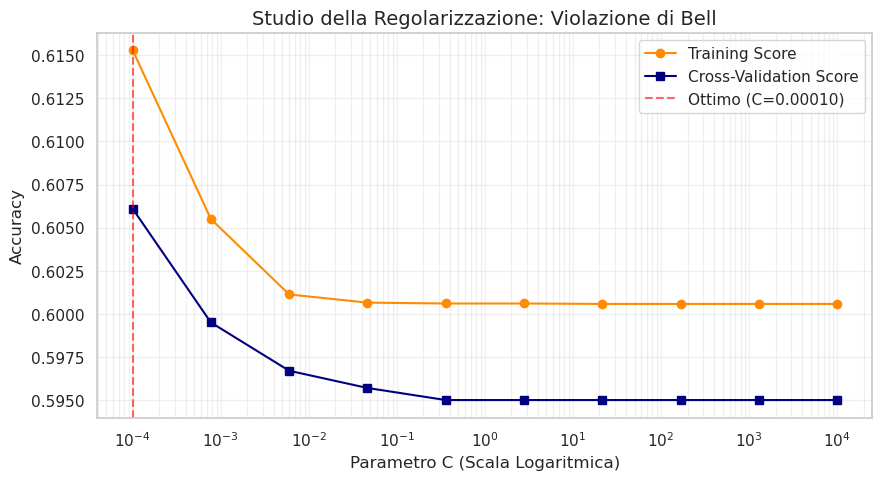

In [10]:
pca = PCA(n_components=n_95)
X_pca = pca.fit_transform(X_scaled)
best_c_ent = studio_miglior_C(df, X_pca, 'is_entangled', 'Entanglement')
best_c_bell = studio_miglior_C(df, X_pca, 'violates_bell', 'Violazione di Bell')

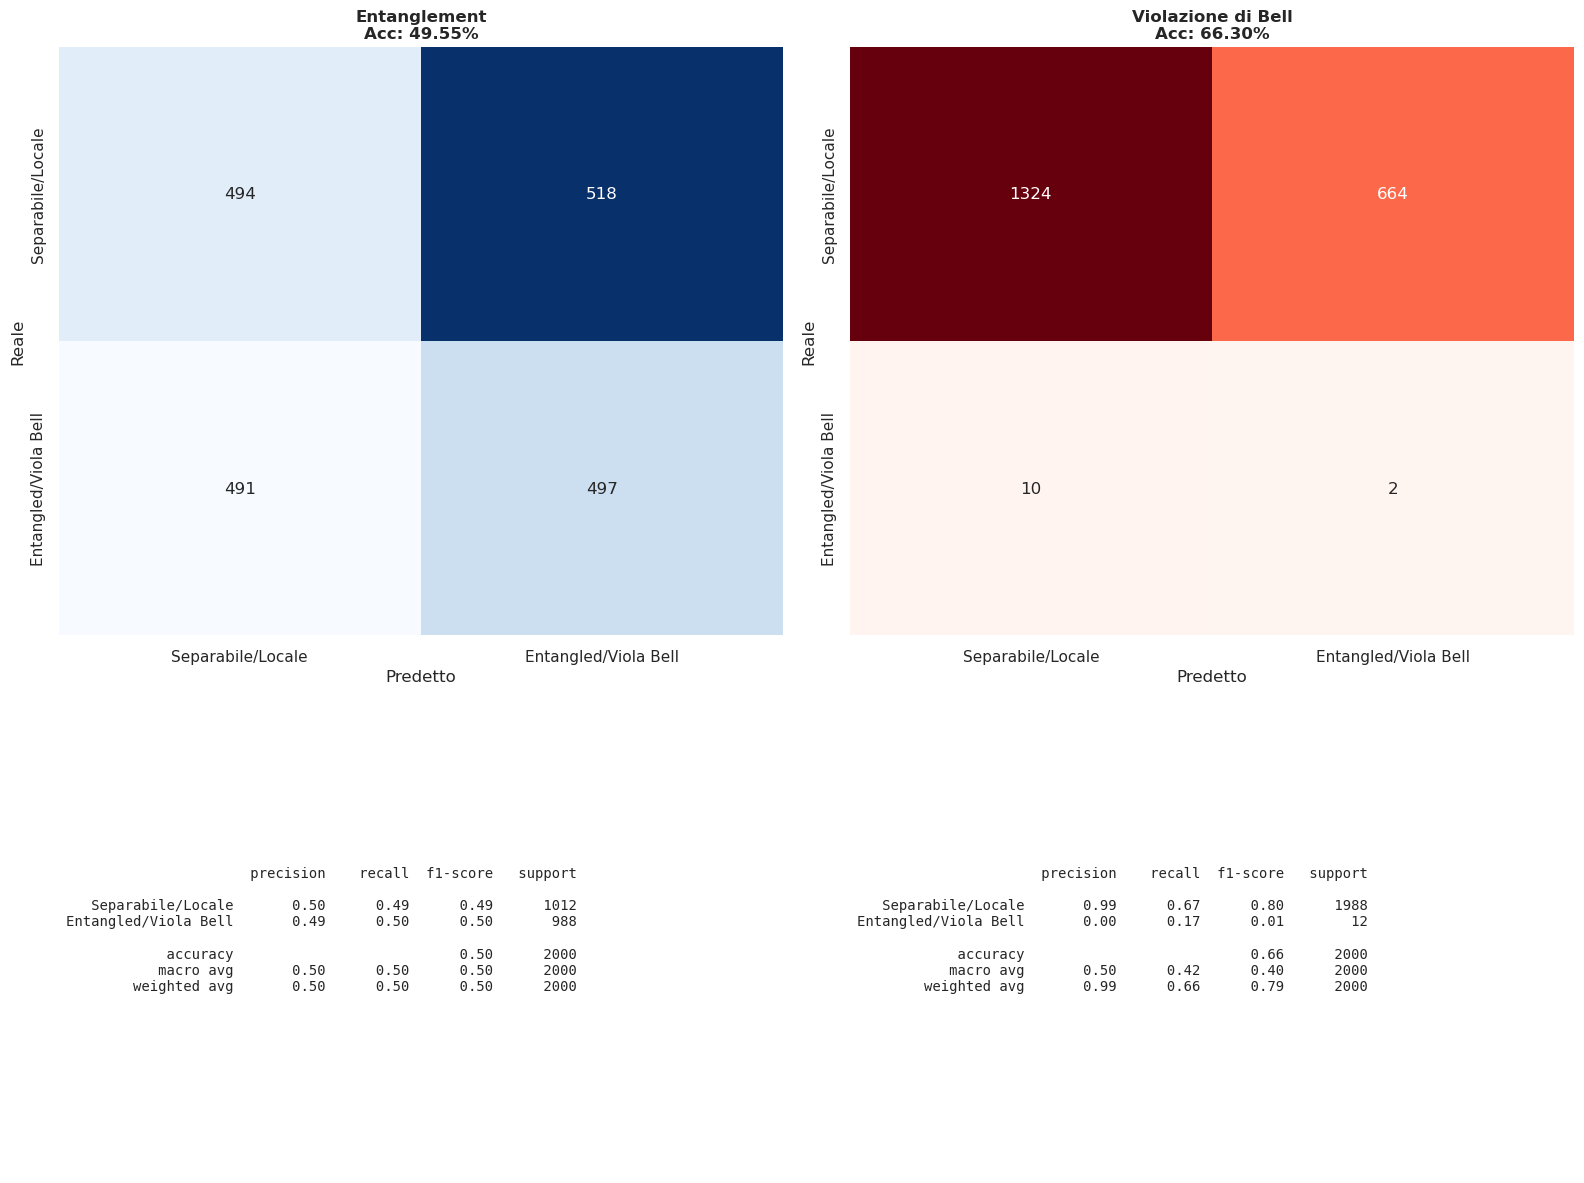

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 0.8]})

model_ent = esegui_e_plotta_tutto(df, X_pca, 'is_entangled', 'Entanglement', 'Blues', axes[0, 0], axes[1, 0],C=best_c_ent)
model_bell = esegui_e_plotta_tutto(df, X_pca, 'violates_bell', 'Violazione di Bell', 'Reds', axes[0, 1], axes[1, 1], C=best_c_bell)

plt.tight_layout()
plt.show()

## Interpretazione dei Pesi del Modello (Feature Importance)
L'analisi dell'importanza delle componenti, condotta osservando i coefficienti assoluti delle features del modello ($|\omega_i|$), rivela la struttura gerarchica dell'informazione. Dal grafico possiamo notare che la presenza di pesi non nulli su componenti successive alle prime suggerisce che la frontiera di entanglement e soprattutto di Bell non è perfettamente allineata con i soli assi di massima varianza, ma richiede una combinazione di feature più sottili per essere definita correttamente.

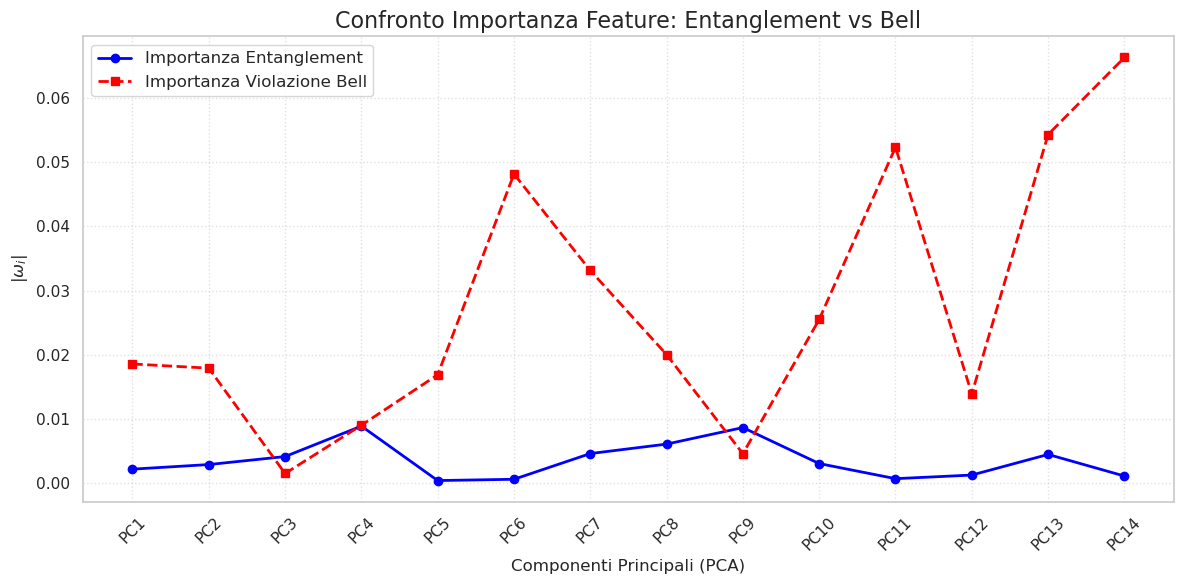

In [12]:
plt.figure(figsize=(12, 6))

importances_ent = np.abs(model_ent.coef_).ravel()
importances_bell = np.abs(model_bell.coef_).ravel()
pcs = [f'PC{i+1}' for i in range(len(importances_ent))]

plt.plot(pcs, importances_ent, marker='o', linestyle='-', linewidth=2, label='Importanza Entanglement', color='blue')
plt.plot(pcs, importances_bell, marker='s', linestyle='--', linewidth=2, label='Importanza Violazione Bell', color='red')

plt.title('Confronto Importanza Feature: Entanglement vs Bell', fontsize=16)
plt.xlabel('Componenti Principali (PCA)', fontsize=12)
plt.ylabel('$|\omega_i|$', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Analisi del Trade-off Bias-Varianza e Ottimizzazione della Complessità

Per garantire che la riduzione dimensionale operata tramite PCA non comprometta la capacità predittiva del modello, è stata condotta un'analisi del trade-off tra Bias e Varianza. Questa valutazione permette di determinare il livello di complessità ottimale del modello (espresso come numero di componenti principali) necessario per catturare la fisica del sistema senza incorrere in fenomeni di overfitting.

#### Metodologia e Metriche di Errore
A differenza delle analisi standard basate sull'errore quadratico medio (MSE), in questo lavoro è stata utilizzata la Log-Loss (Entropia Incrociata) come metrica di costo. La Log-Loss risulta più indicata per la classificazione quantistica poiché è estremamente sensibile alla confidenza delle probabilità predette:
- *Errore di Train (Bias^2):* Matematicamente, misura quanto le previsioni del modello si discostano dai valori reali dei dati che il modello ha già visto.
- *Varianza:* Rappresenta il gap di generalizzazione. Indica quanto peggiorano le prestazioni del modello quando passa dai dati di addestramento a quelli di test.
- *Errore Totale:* Rappresenta quanto il classificatore sia effettivamente affidabile quando gli vengono forniti dati mai visti prima.

In [13]:
errori = estrai_errori_singoli(X_pca, y)
print(f"Bias^2: {errori['Bias_Quadrato']:.4f}")
print(f"Varianza: {errori['Varianza']:.4f}")
print(f"Errore totale: {errori['Errore_Totale']:.4f}")

Bias^2: 0.6312
Varianza: 0.0017
Errore totale: 0.6329


## Classificazione Non-Lineare tramite Support Vector Machines (SVM)

Per catturare la complessa geometria della frontiera di separabilità, che la teoria quantistica descrive come un insieme convesso ma con confini non-lineari nello spazio delle matrici densità, è stato implementato un classificatore basato sulle *Support Vector Machines* (SVM). 

#### Architettura del Modello e Kernel RBF
A differenza del modello lineare baseline, l'SVM utilizza un *Kernel a Funzione di Base Radiale (RBF)* definita come segue:
$$K(x,x')=e^{-\gamma ||x-x'||^2}$$
Questa permette di proiettare implicitamente i dati in uno spazio delle feature a dimensionalità infinita. Questo approccio è particolarmente efficace per il problema in esame poiché:
- *Cattura delle Finiture Geometriche:* il criterio di separabilità (come il criterio PPT o quello di Horodecki) non segue semplici iperpiani nello spazio delle componenti principali. L'SVM con kernel RBF è in grado di modellare ipersuperfici di decisione curve, adattandosi meglio alla curvatura naturale della regione degli stati entangled.
- *Ottimizzazione del Margine:* l'algoritmo mira a massimizzare il margine tra le classi, migliorando la capacità di generalizzazione sugli stati che si trovano in prossimità del limite critico di violazione.
- *Iperparametri:* sono stati utilizzati parametri di regolarizzazione e il coefficiente del kernel ($\gamma$) migliore, scalato sulla varianza delle feature, garantendo un equilibrio tra precisione e tolleranza al rumore.


## Ottimizzazione degli Iperparametri e Analisi della Superficie di Accuratezza

La performance di un classificatore SVM con kernel RBF è strettamente dipendente dalla scelta di due iperparametri critici: il parametro di regolarizzazione ($C$) e l'ampiezza del kernel ($\gamma$). Per identificare la configurazione ottimale, è stata condotta una *Grid Search* con *Stratified 5-Fold Cross-Validation*, visualizzando i risultati attraverso una heatmap della superficie di accuratezza.

#### Significato Fisico degli Iperparametri
L'equilibrio tra questi due parametri determina la capacità del modello di generalizzare la fisica degli stati quantistici:
- *Parametro $C$:* Regola il trade-off tra la massimizzazione del margine e la minimizzazione dell'errore di addestramento. Un valore di $C$ elevato impone una classificazione rigida di tutti i punti (rischiando l'overfitting), mentre un $C$ ridotto permette una frontiera più morbida, tollerando eventuali stati rumorosi o outliers in prossimità del confine di separabilità.
- *Parametro $\gamma$:* Definisce la portata dell'influenza di un singolo stato quantistico nel determinare la frontiera di decisione. Valori elevati di $\gamma$ portano a una frontiera molto complessa e irregolare che tenta di circondare ogni singolo Support Vector, mentre valori bassi producono una separazione più liscia e globale nello spazio delle componenti principali.

#### Analisi della Heatmap di Ottimizzazione
La heatmap prodotta permette di identificare visivamente la *regione di stabilità* del modello:
- *Identificazione del Massimo Globale:* Il punto di massima accuratezza (evidenziato dai valori più scuri/intensi nella mappa) rappresenta il miglior compromesso tra capacità predittiva e robustezza.
- *Analisi di Sensibilità:* Una vasta area di colori uniformi indica che il modello è resiliente a piccole variazioni dei parametri, suggerendo che la struttura informativa estratta dalla PCA è solida. Al contrario, picchi di accuratezza isolati potrebbero indicare configurazioni instabili dipendenti da fluttuazioni stocastiche del dataset.


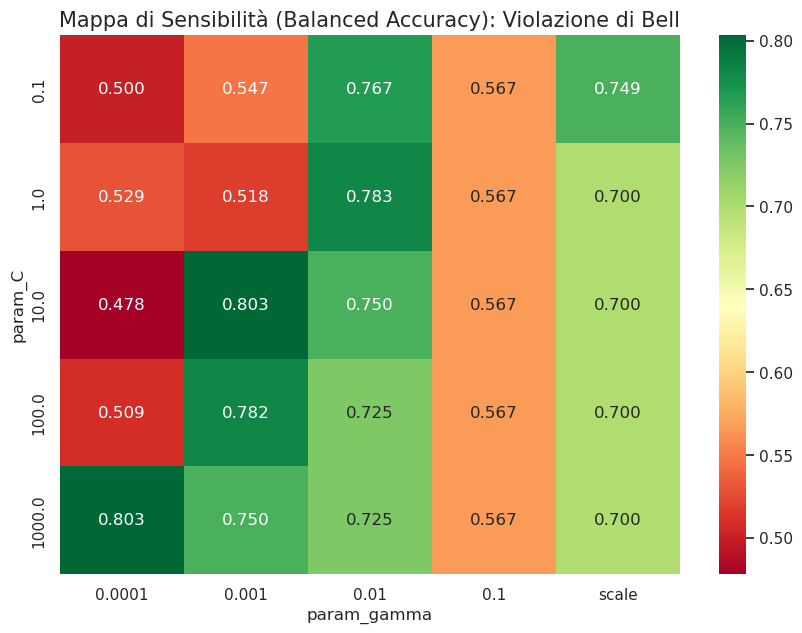

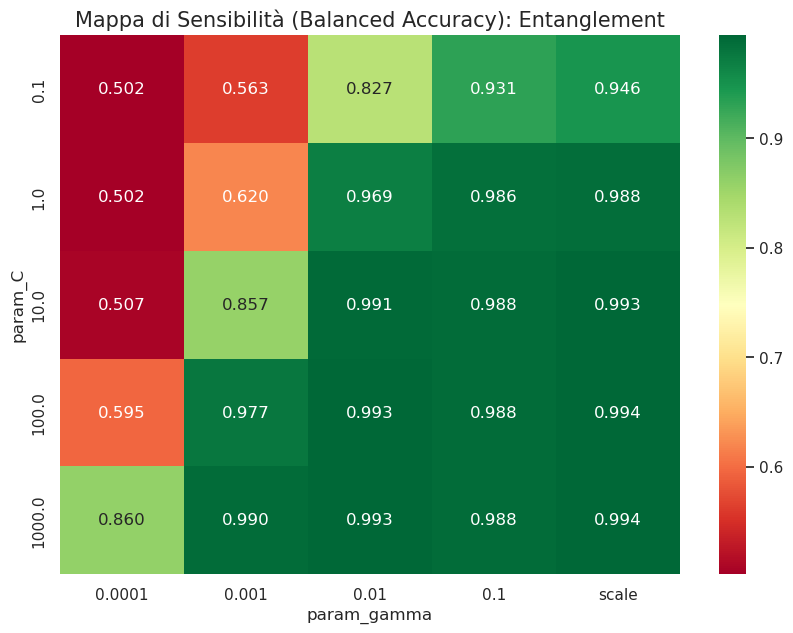

Migliori parametri Entanglement: {'C': 100, 'gamma': 'scale'}
Migliori parametri Bell: {'C': 1000, 'gamma': 0.0001}


In [14]:
best_p_bell = plot_svm_heatmap_v2(X_pca, df['violates_bell'], "Violazione di Bell")
best_p_ent = plot_svm_heatmap_v2(X_pca, df['is_entangled'], "Entanglement")

print("Migliori parametri Entanglement:", best_p_ent)
print("Migliori parametri Bell:", best_p_bell)

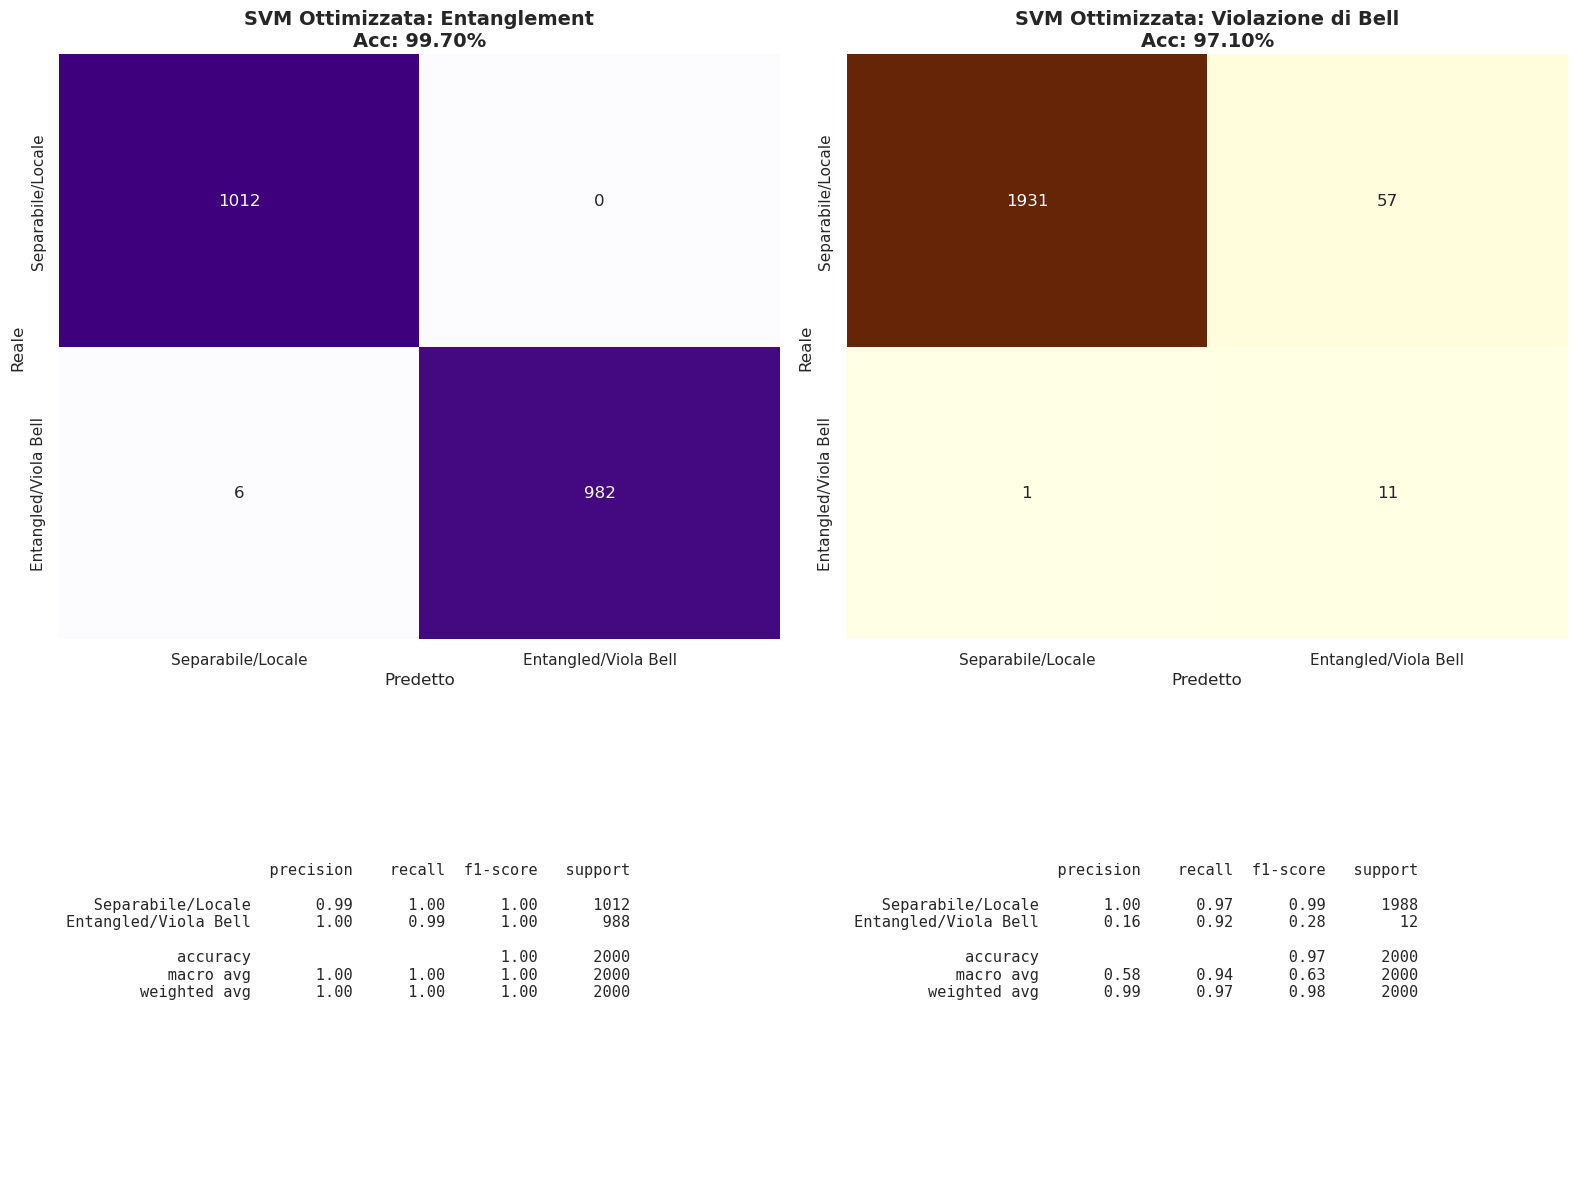

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 0.8]})

model_svm_ent = esegui_svm_e_plotta(df, X_pca, 'is_entangled', 'Entanglement', 'Purples', axes[0, 0], axes[1, 0], best_p_ent)
model_svm_bell = esegui_svm_e_plotta(df, X_pca, 'violates_bell', 'Violazione di Bell', 'YlOrBr', axes[0, 1], axes[1, 1], best_p_bell)

plt.tight_layout()
plt.show()

## Interpretazione del Modello SVM: Permutation Importance

A differenza dei modelli lineari, le *Support Vector Machines* con kernel RBF operano in uno spazio delle feature trasformato, rendendo impossibile l'ispezione diretta dei coefficienti. Per ovviare a questa limitazione e determinare quali componenti principali siano realmente discriminanti per la classificazione quantistica, è stata applicata la tecnica della *Permutation Importance*.

#### Metodologia di Valutazione
La Permutation Importance misura l'importanza di una feature valutando quanto diminuisce l'accuratezza del modello quando i valori di tale feature vengono permutati casualmente. Se una componente principale è fondamentale per identificare l'entanglement, la sua "distruzione" tramite shuffling comporterà un crollo drastico delle performance. Questo approccio presenta diversi vantaggi:
- *Indipendenza dal Modello:* È una tecnica agnostica che permette di confrontare l'importanza delle feature tra modelli diversi
- *Cattura delle Interazioni:* Identifica non solo l'importanza individuale della componente, ma anche quanto il modello faccia affidamento sulle relazioni non lineari tra le componenti stesse

#### Validazione della Riduzione Dimensionale
L'osservazione di valori di importanza quasi nulli per le componenti d'ordine più elevato fornisce una *validazione a posteriori* della scelta del numero di componenti. Il fatto che il modello SVM non "soffra" della rimozione o della permutazione delle ultime componenti indica che l'informazione fisica necessaria è stata correttamente condensata nei primi vettori dello spazio latente, minimizzando al contempo l'impatto del rumore numerico.


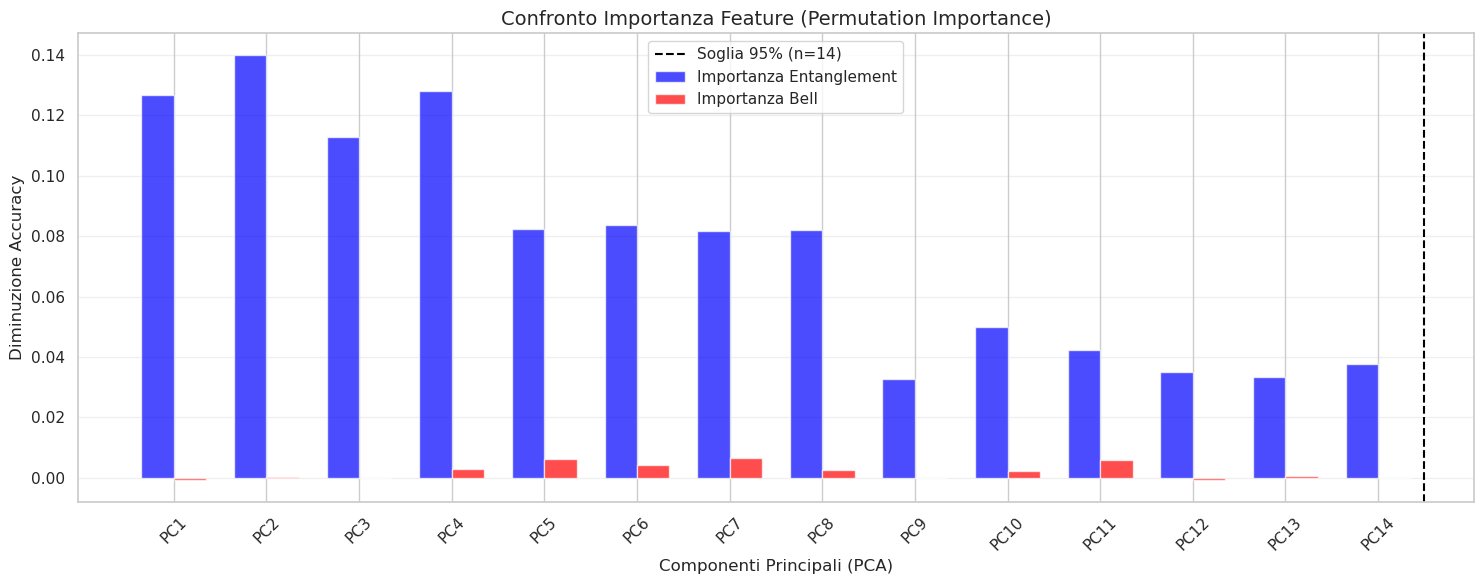

In [16]:
plot_confronto_permutation(model_ent=model_svm_ent, model_bell=model_svm_bell, df=df, X_pca=X_pca, n_95=n_95)

## Analisi del Trade-off Bias-Varianza e Ottimizzazione della Complessità

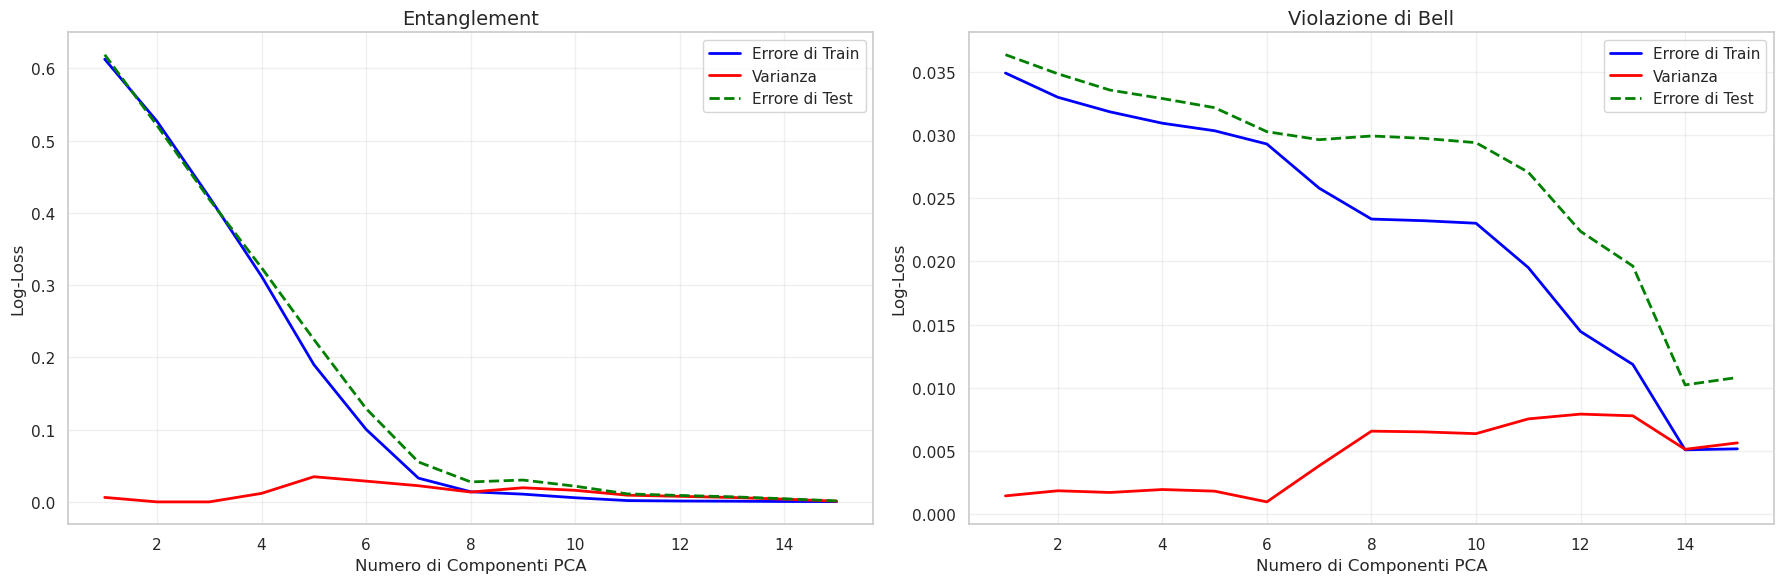

In [43]:
comp_r_ent, bias_ent, var_ent, err_ent = calcola_metrics_bv_svm(X_scaled, df['is_entangled'], max_comp=15, best_params=best_p_ent)

comp_r_bell, bias_bell, var_bell, err_bell = calcola_metrics_bv_svm(X_scaled, df['violates_bell'], max_comp=15, best_params=best_p_bell)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Entanglement
ax1.plot(comp_r_ent, bias_ent, label='Errore di Train', color='blue', lw=2)
ax1.plot(comp_r_ent, var_ent, label='Varianza', color='red', lw=2)
ax1.plot(comp_r_ent, err_ent, label='Errore di Test', color='green', linestyle='--', lw=2)
ax1.set_title('Entanglement', fontsize=14)
ax1.set_xlabel('Numero di Componenti PCA')
ax1.set_ylabel('Log-Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Violazione di Bell
ax2.plot(comp_r_bell, bias_bell, label='Errore di Train', color='blue', lw=2)
ax2.plot(comp_r_bell, var_bell, label='Varianza', color='red', lw=2)
ax2.plot(comp_r_bell, err_bell, label='Errore di Test', color='green', linestyle='--', lw=2)
ax2.set_title('Violazione di Bell', fontsize=14)
ax2.set_xlabel('Numero di Componenti PCA')
ax2.set_ylabel('Log-Loss')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Analisi dei Support Vectors: Identificazione degli Stati Critici

Per approfondire la comprensione di come il modello SVM mappi lo spazio di Hilbert, è stata condotta un'analisi della distribuzione fisica dei *Support Vectors* (SV). In un'architettura SVM, i vettori di supporto sono gli unici punti del dataset che determinano attivamente la posizione e la forma della frontiera di decisione; essi rappresentano i casi più "difficili" o ambigui, situati in prossimità del margine di separazione tra le classi.

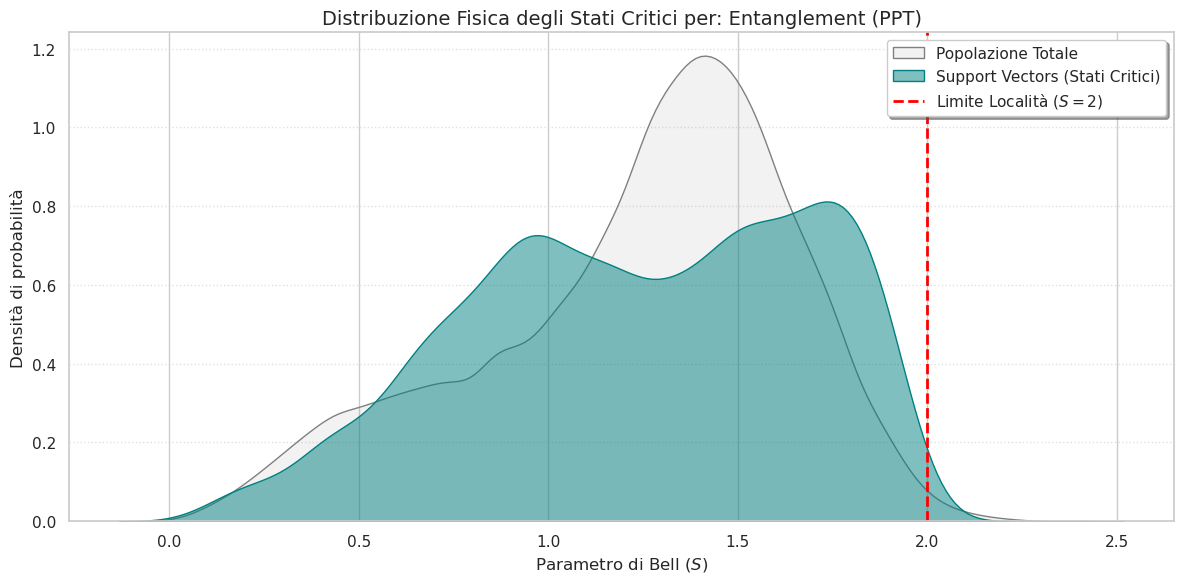

--- Insight per Entanglement (PPT) ---
Numero di Support Vectors: 789 (9.9%)
Valore medio di S per gli Stati Critici: 1.239


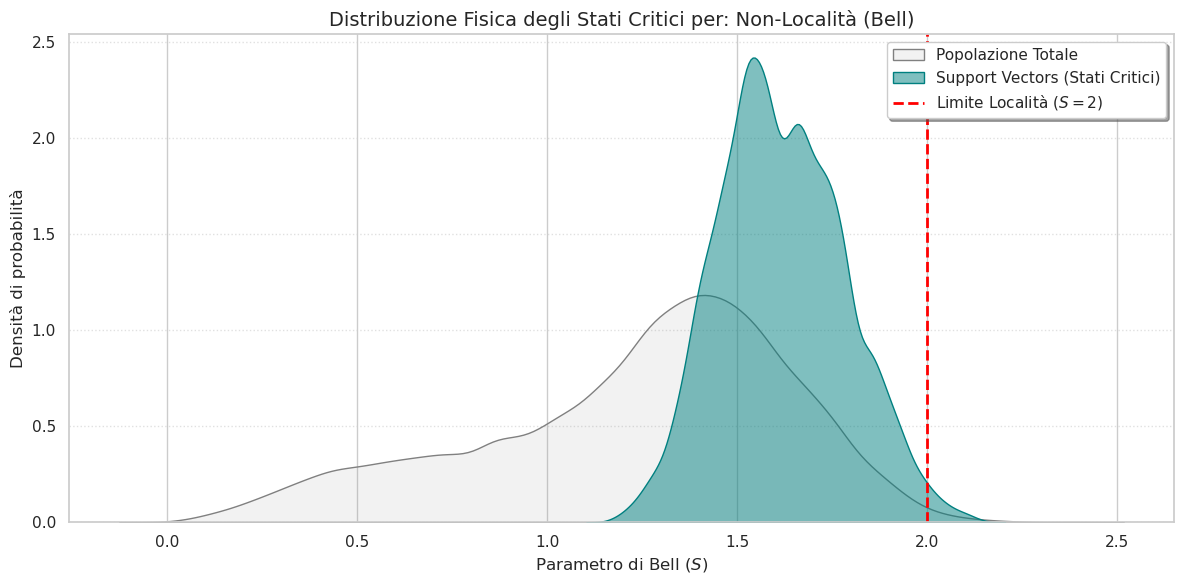

--- Insight per Non-Località (Bell) ---
Numero di Support Vectors: 2504 (31.3%)
Valore medio di S per gli Stati Critici: 1.616


In [44]:
analizza_support_vectors(model_svm_ent, df, X_pca, 'is_entangled')
analizza_support_vectors(model_svm_bell, df, X_pca, 'violates_bell')

## MLP

Le reti MLP sono architetture neurali feed-forward in cui l'informazione fluisce unidirezionalmente attraverso strati di neuroni completamente connessi tra loro (input, hidden e output).
- *Logica del Neurone*: Ogni unità esegue una combinazione lineare pesata dei dati in ingresso, $z=w^Tx+b$, seguita da una funzione di attivazione non lineare $f(z)$ che permette alla rete di apprendere relazioni complesse.
- *Capacità Computazionale*: Grazie al *Teorema di Approssimazione Universale*, un MLP con almeno uno strato nascosto può approssimare qualsiasi funzione continua con precisione arbitraria.
- *Addestramento*: I parametri (pesi e bias) vengono ottimizzati tramite la discesa algoritmi specifici e l'algoritmo di back-propagation, che propaga l'errore dallo strato di output a ritroso per aggiornare la rete.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy

In [30]:
target_col_ent = 'is_entangled'

if df[target_col_ent].dtype == object:
    y_ent = df[target_col_ent].astype(str).str.contains('Entangled|1|True').astype(int).values
else:
    y_ent = df[target_col_ent].fillna(0).astype(int).values

X_train_ent, X_test_ent, y_train_ent, y_test_ent = train_test_split(
    X_pca, y_ent, test_size=0.2, random_state=42
)

target_col_bell = 'violates_bell'

if df[target_col_bell].dtype == object:
    y_bell = df[target_col_bell].astype(str).str.contains('Viola|1|True').astype(int).values
else:
    y_bell = df[target_col_bell].fillna(0).astype(int).values

X_train_bell, X_test_bell, y_train_bell, y_test_bell = train_test_split(
    X_pca, y_bell, test_size=0.2, random_state=42
)

In [31]:
X_train_ent_t = torch.FloatTensor(X_train_ent)
y_train_ent_t = torch.FloatTensor(y_train_ent).view(-1, 1)
X_test_ent_t = torch.FloatTensor(X_test_ent)
y_test_ent_t = torch.FloatTensor(y_test_ent).view(-1, 1)

train_loader_ent = DataLoader(
    TensorDataset(X_train_ent_t, y_train_ent_t), batch_size=64, shuffle=True
)

X_train_bell_t = torch.FloatTensor(X_train_bell)
y_train_bell_t = torch.FloatTensor(y_train_bell).view(-1, 1)
X_test_bell_t = torch.FloatTensor(X_test_bell)
y_test_bell_t = torch.FloatTensor(y_test_bell).view(-1, 1)

train_loader_bell = DataLoader(
    TensorDataset(X_train_bell_t, y_train_bell_t), batch_size=64, shuffle=True
)

search_config = {
    'activations': {'ELU': nn.ELU, 'SiLU': nn.SiLU, 'LeakyReLU': nn.LeakyReLU},
    'optimizers': {'AdamW': optim.AdamW, 'RMSprop': optim.RMSprop},
    'learning_rates': [0.001, 0.0005]
}

## Ottimizzazione degli iperparametri e Grid Search
Al fine di identificare la configurazione architetturale e algoritmica ottimale per il modello, è stata implementata una procedura di *Grid Search* sistematica. Inizialmente, per contrastare il potenziale sbilanciamento delle classi nel dataset di addestramento, è stato calcolato un fattore di pesatura dei positivi, definito come $pos\_weight = \frac{N_{neg}}{N_{pos}}$, integrato successivamente nella funzione di perdita *BCEWithLogitsLoss*. 

Lo spazio di ricerca degli iperparametri ha previsto la valutazione incrociata di diverse funzioni di attivazione ($\text{ELU}$, $\text{SiLU}$, $\text{LeakyReLU}$), algoritmi di ottimizzazione ($\text{AdamW}$, $\text{RMSprop}$) e tassi di apprendimento ($0.001$, $0.0005$). Il processo di selezione automatizzata ha analizzato ogni combinazione mediante un ciclo di addestramento con *early stopping*, basato sulla minimizzazione della *validation loss*. Al termine della procedura, la configurazione che ha garantito la massima *balanced accuracy* sul set di test è stata salvata e selezionata come modello finale per le analisi di convergenza e classificazione.

### Entanglement

In [32]:
n_pos_ent = sum(y_train_ent)
pos_weight_ent = torch.tensor([(len(y_train_ent) - n_pos_ent) / n_pos_ent])

print("Grid Search: Entanglement")
best_cfg_ent, best_acc_ent = run_grid_search(
    input_dim=n_95, 
    train_loader=train_loader_ent, 
    X_test_t=X_test_ent_t, 
    y_test_t=y_test_ent_t, 
    y_test_raw=y_test_ent, 
    pos_weight=pos_weight_ent, 
    config=search_config
)

print(f"\nMiglior Configurazione Entanglement: {best_cfg_ent} con Accuracy: {best_acc_ent:.2%}")

Grid Search: Entanglement
Activation | Opt      | LR      | Epoch | Val Loss | B. Acc
---------------------------------------------------------------------------
ELU        | AdamW    | 0.001   | 88    | 0.0171   | 99.34%
ELU        | AdamW    | 0.0005  | 127   | 0.0203   | 99.29%
ELU        | RMSprop  | 0.001   | 119   | 0.0131   | 99.54%
ELU        | RMSprop  | 0.0005  | 148   | 0.0145   | 99.49%
SiLU       | AdamW    | 0.001   | 83    | 0.0129   | 99.49%
SiLU       | AdamW    | 0.0005  | 125   | 0.0165   | 99.54%
SiLU       | RMSprop  | 0.001   | 98    | 0.0113   | 99.70%
SiLU       | RMSprop  | 0.0005  | 124   | 0.0129   | 99.60%
LeakyReLU  | AdamW    | 0.001   | 92    | 0.0166   | 99.65%
LeakyReLU  | AdamW    | 0.0005  | 149   | 0.0141   | 99.54%
LeakyReLU  | RMSprop  | 0.001   | 91    | 0.0184   | 99.70%
LeakyReLU  | RMSprop  | 0.0005  | 48    | 0.0299   | 98.99%

Miglior Configurazione Entanglement: ('SiLU', 'RMSprop', 0.001) con Accuracy: 99.70%


### Violazione di Bell

In [33]:
n_pos_bell = sum(y_train_bell)
pos_weight_bell = torch.tensor([(len(y_train_bell) - n_pos_bell) / n_pos_bell])

print("Grid Search: Violazione Di Bell")
best_cfg_bell, best_acc_bell = run_grid_search(
    input_dim=n_95, 
    train_loader=train_loader_bell, 
    X_test_t=X_test_bell_t, 
    y_test_t=y_test_bell_t, 
    y_test_raw=y_test_bell, 
    pos_weight=pos_weight_bell, 
    config=search_config
)

print(f"\nMiglior Configurazione Bell: {best_cfg_bell} con Accuracy: {best_acc_bell:.2%}")

Grid Search: Violazione Di Bell
Activation | Opt      | LR      | Epoch | Val Loss | B. Acc
---------------------------------------------------------------------------
ELU        | AdamW    | 0.001   | 31    | 0.9165   | 85.78%
ELU        | AdamW    | 0.0005  | 54    | 0.3918   | 93.29%
ELU        | RMSprop  | 0.001   | 50    | 0.8979   | 85.71%
ELU        | RMSprop  | 0.0005  | 42    | 0.7949   | 79.38%
SiLU       | AdamW    | 0.001   | 26    | 0.9247   | 82.55%
SiLU       | AdamW    | 0.0005  | 41    | 0.6588   | 76.58%
SiLU       | RMSprop  | 0.001   | 26    | 1.1626   | 68.76%
SiLU       | RMSprop  | 0.0005  | 31    | 1.1242   | 72.68%
LeakyReLU  | AdamW    | 0.001   | 26    | 0.8781   | 77.34%
LeakyReLU  | AdamW    | 0.0005  | 28    | 1.2298   | 66.35%
LeakyReLU  | RMSprop  | 0.001   | 28    | 1.4319   | 60.33%
LeakyReLU  | RMSprop  | 0.0005  | 33    | 1.2985   | 70.64%

Miglior Configurazione Bell: ('ELU', 'AdamW', 0.0005) con Accuracy: 93.29%


### Training modello finale: Entanglement

Avvio training finale: SiLU + RMSprop per 450 epoche...
Epoch [50/450] - Train Loss: 0.0283 | Test Loss: 0.0145
Epoch [100/450] - Train Loss: 0.0135 | Test Loss: 0.0128
Epoch [150/450] - Train Loss: 0.0093 | Test Loss: 0.0127
Epoch [200/450] - Train Loss: 0.0088 | Test Loss: 0.0142
Epoch [250/450] - Train Loss: 0.0073 | Test Loss: 0.0176
Epoch [300/450] - Train Loss: 0.0071 | Test Loss: 0.0169
Epoch [350/450] - Train Loss: 0.0077 | Test Loss: 0.0202
Epoch [400/450] - Train Loss: 0.0073 | Test Loss: 0.0169
Epoch [450/450] - Train Loss: 0.0074 | Test Loss: 0.0165


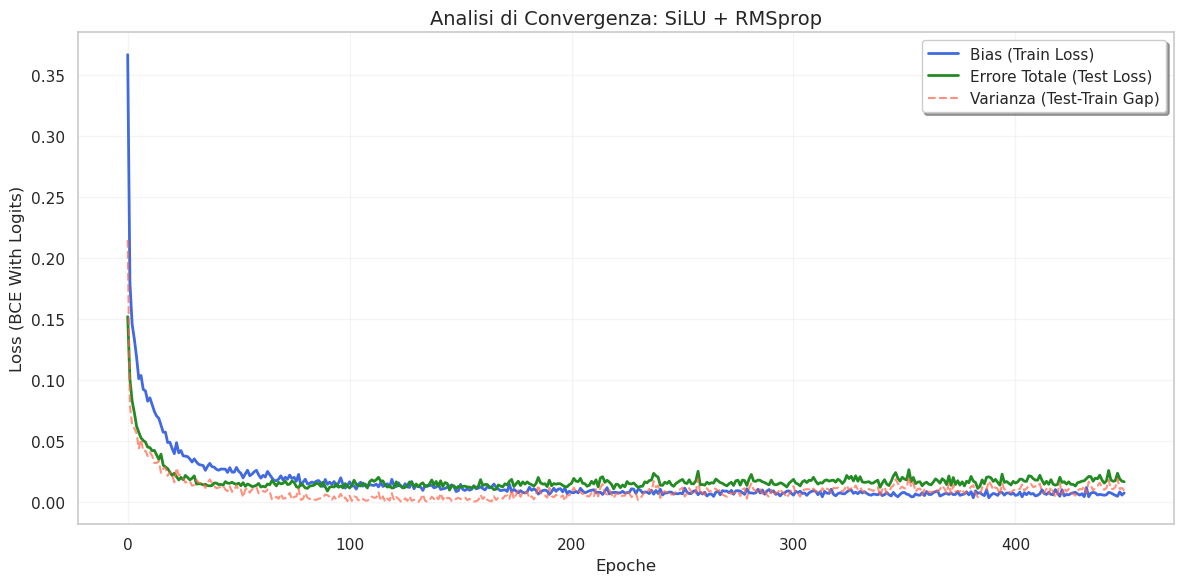

In [36]:
# Training con i parametri migliori per l'entanglement
final_model_ent, history_ent = train_final_model(
    best_params=best_cfg_ent, 
    search_config=search_config, 
    input_dim=n_95, 
    train_loader=train_loader_ent, 
    X_test_t=X_test_ent_t, 
    y_test_t=y_test_ent_t, 
    pos_weight=pos_weight_ent,
    epochs=450
)

# Plot dell'analisi di convergenza per Entanglement
plot_convergence_analysis(history_ent, best_cfg_ent)

### Training modello finale: Violazione di Bell

Avvio training finale: ELU + AdamW per 450 epoche...
Epoch [50/450] - Train Loss: 0.2214 | Test Loss: 1.2740
Epoch [100/450] - Train Loss: 0.0553 | Test Loss: 2.4977
Epoch [150/450] - Train Loss: 0.1240 | Test Loss: 1.7205
Epoch [200/450] - Train Loss: 0.0797 | Test Loss: 3.0147
Epoch [250/450] - Train Loss: 0.1150 | Test Loss: 3.0578
Epoch [300/450] - Train Loss: 0.0259 | Test Loss: 4.8229
Epoch [350/450] - Train Loss: 0.0337 | Test Loss: 4.4606
Epoch [400/450] - Train Loss: 0.0361 | Test Loss: 6.2362
Epoch [450/450] - Train Loss: 0.0457 | Test Loss: 4.5189


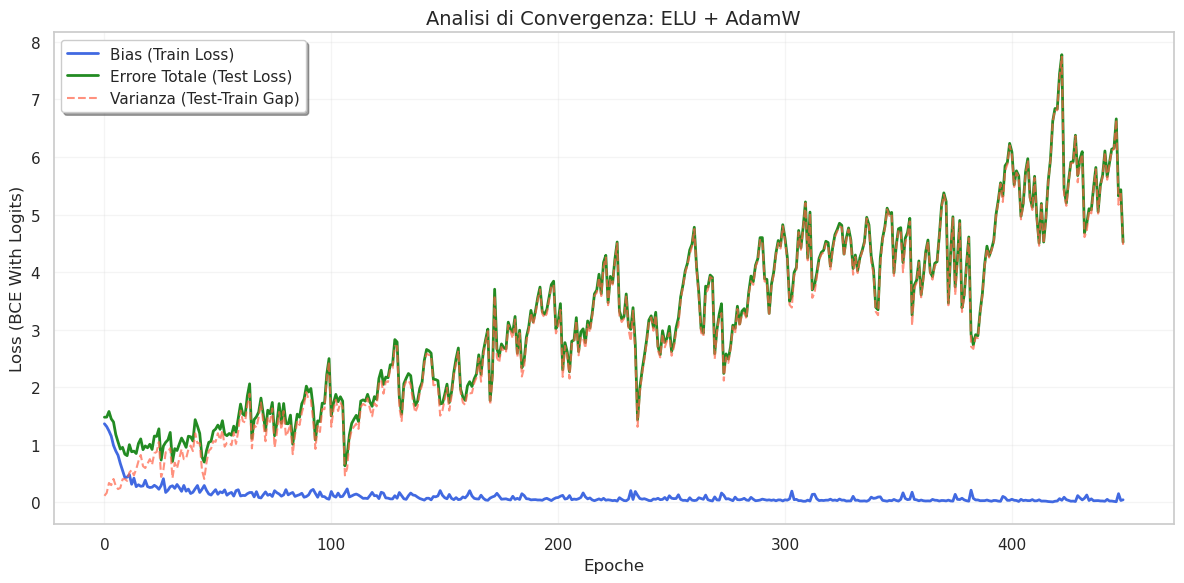

In [37]:
# Training con i parametri migliori per la violazione di Bell
final_model_bell, history_bell = train_final_model(
    best_params=best_cfg_bell, 
    search_config=search_config, 
    input_dim=n_95, 
    train_loader=train_loader_bell, 
    X_test_t=X_test_bell_t, 
    y_test_t=y_test_bell_t, 
    pos_weight=pos_weight_bell,
    epochs=450
)

# Plot dell'analisi di convergenza per Bell
plot_convergence_analysis(history_bell, best_cfg_bell)

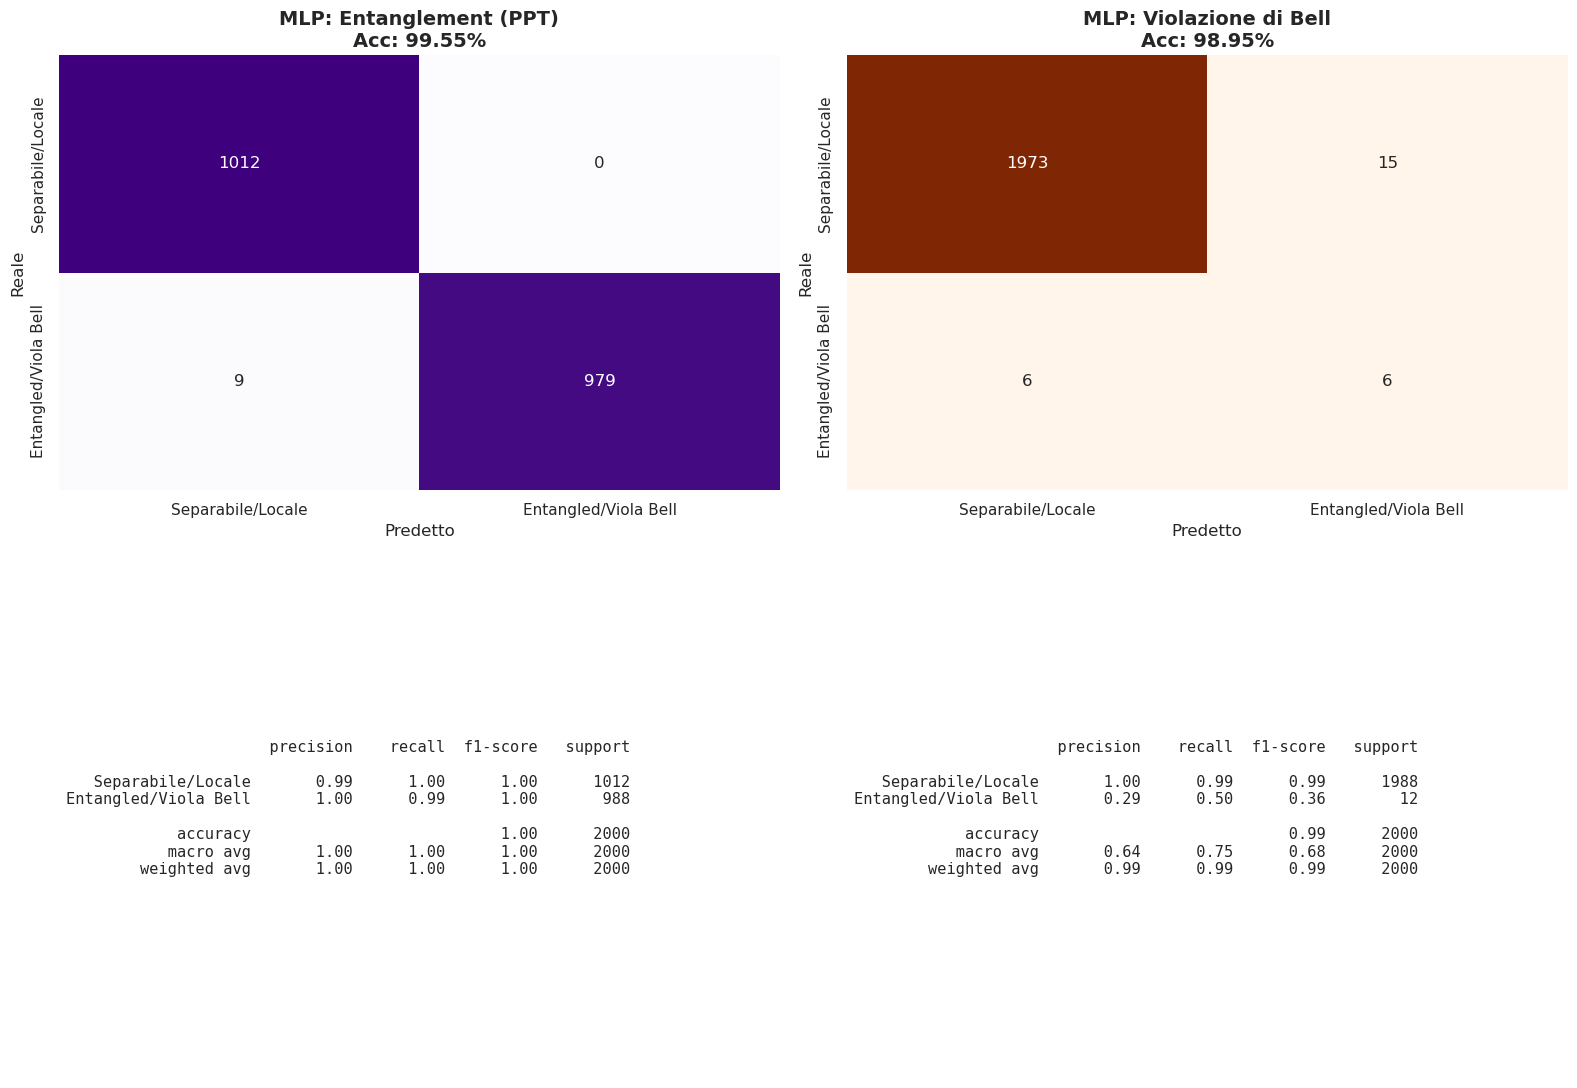

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 1.2]})

esegui_mlp_e_plotta(
    model=final_model_ent, 
    X_test_t=X_test_ent_t, 
    y_test_raw=y_test_ent, 
    nome_target="Entanglement (PPT)", 
    mappa_colore="Purples", 
    ax_matrix=axes[0, 0], 
    ax_text=axes[1, 0]
)

esegui_mlp_e_plotta(
    model=final_model_bell, 
    X_test_t=X_test_bell_t, 
    y_test_raw=y_test_bell, 
    nome_target="Violazione di Bell", 
    mappa_colore="Oranges", 
    ax_matrix=axes[0, 1], 
    ax_text=axes[1, 1]
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()